##### **Step 0:** 
- Import libraries
- Configure plotting settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# For better looking graphs
plt.rc("figure", autolayout=True, figsize=(8, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

##### **Step 1:** 
- Analyse the `customers` dataset
- Calculate customers' average age

Let's start with understanding the clients data and analysing its quality - null values, duplicates, possible invalid values, etc.

In [3]:
customers = pd.read_parquet("customers.parquet", engine='pyarrow')

print("Shape: ", customers.shape)

customers.head()

Shape:  (2500, 4)


,ID,GENDER,AGE,INCOME
0,M5FQZHG1,F,37,10843.0
1,JPOALDTW,M,38,9419.0
2,QHJXRE6A,M,37,10850.0
3,LKS17XRW,M,35,10107.0
4,V5UPOIAW,F,34,10323.0


In [4]:
print("Types: ")
customers.dtypes

Types: 


ID         object
GENDER     object
AGE         int64
INCOME    float64
dtype: object

In [5]:
print("Null values: ")
customers.isna().sum()

Null values: 


ID          0
GENDER      0
AGE         0
INCOME    375
dtype: int64

In [6]:
print("Ratio of null values in INCOME:", customers['INCOME'].isna().sum() / customers.shape[0])

customers[customers['INCOME'].isna()]

Ratio of null values in INCOME: 0.15


,ID,GENDER,AGE,INCOME
18,ZDYP8KXH,F,30,NaN
44,VCITAAQ3,F,35,NaN
48,3II5AT8M,M,26,NaN
59,TAZDLD5N,F,36,NaN
60,FMUXPHSM,F,41,NaN
...,...,...,...,...
2472,92I2GTOY,M,32,NaN
2473,SZ7WCYLU,M,38,NaN
2476,TQEAMC3L,F,33,NaN
2478,BONNZAFF,F,28,NaN


We will deal with these null values later.

In [7]:
print("Number of duplicated rows:", customers.duplicated().sum())

print("Number of duplicated IDs:", customers['ID'].duplicated().sum())

Number of duplicated rows: 0
Number of duplicated IDs: 0


In [8]:
customers['GENDER'].value_counts()

GENDER
M    1262
F    1238
Name: count, dtype: int64

In [9]:
customers.describe().style.format("{:.2f}")

,AGE,INCOME
count,2500.00,2125.00
mean,859027.84,10002.90
std,42949672.25,1019.85
min,19.00,6163.00
25%,31.00,9327.00
50%,34.00,9982.00
75%,38.00,10690.00
max,2147483647.00,13377.00


The maximum value of age seems invalid. Let's sort the age column and see the last values.

In [10]:
customers.sort_values(by='AGE').tail(10)

,ID,GENDER,AGE,INCOME
839,5PHYA0/R,M,48,9515.0
2085,OA0G2SJ4,F,49,11515.0
559,WWCL3CGS,M,49,NaN
544,E2KLNXXV,M,49,9027.0
1279,3KN06IMP,F,49,12048.0
2020,YGD6BS+9,M,50,11895.0
343,C2TDZIOE,F,50,10746.0
1754,2UCEJJCH,M,51,11597.0
933,VMUCC1EP,M,54,11392.0
1000,S4MBAPHB,F,2147483647,9831.0


Clearly some mistake here, we can either drop the rown or impute the value with the mean value.

In [11]:
mean_age = round(customers['AGE'][customers['AGE'] < 150].mean())

customers['AGE'] = customers['AGE'].apply(lambda x: mean_age if x > 150 else x)

mean_age = round(customers['AGE'].mean(), 2)
print("Average age:", mean_age)

Average age: 34.4


In [12]:
customers.describe().style.format("{:.2f}")

,AGE,INCOME
count,2500.00,2125.00
mean,34.40,10002.90
std,5.02,1019.85
min,19.00,6163.00
25%,31.00,9327.00
50%,34.00,9982.00
75%,38.00,10690.00
max,54.00,13377.00


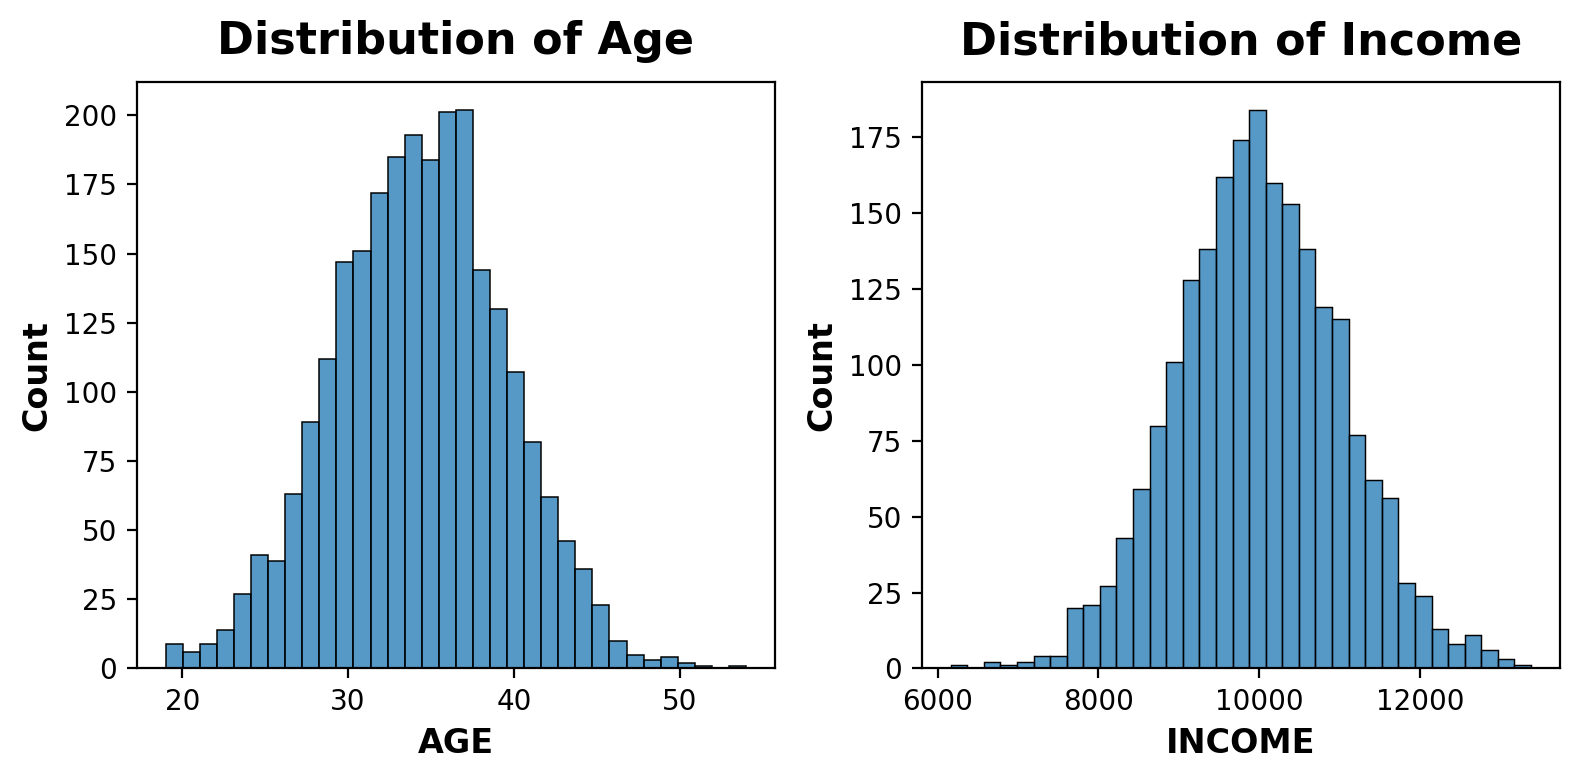

In [13]:
fig, axes = plt.subplots(1, 2)

sns.histplot(customers['AGE'], ax=axes[0])
axes[0].set_title("Distribution of Age")

sns.histplot(customers['INCOME'], ax=axes[1])
axes[1].set_title("Distribution of Income")

plt.show()

Now everything looks good. Let's get back to those null values in the INCOME column. Some algorithms that I will be using later won't be able to work with null values. There are several ways we can deal with them. But first, we need to understand their nature. The best approach would be to contact the person responsible for collecting this data and consult with them (Is it just an unnecessary field? Is it corrupt data? Are people with no income advised to leave the field empty when filling out the information about themselves?). But since we aren't able to get more information about it here, we will have to go through the options ourselves.

First of all, these could be people without income, in which case we could impute it with 0. If this is the case, they could form an important cluster of people and be part of some correlations. Additionally, common techniques include imputing null values with the mean/median value. A more advanced technique would be to impute them with values based on other features, like AGE or GENDER, if we believe there is a correlation between these features and our column of interest. Let's see if there's any.

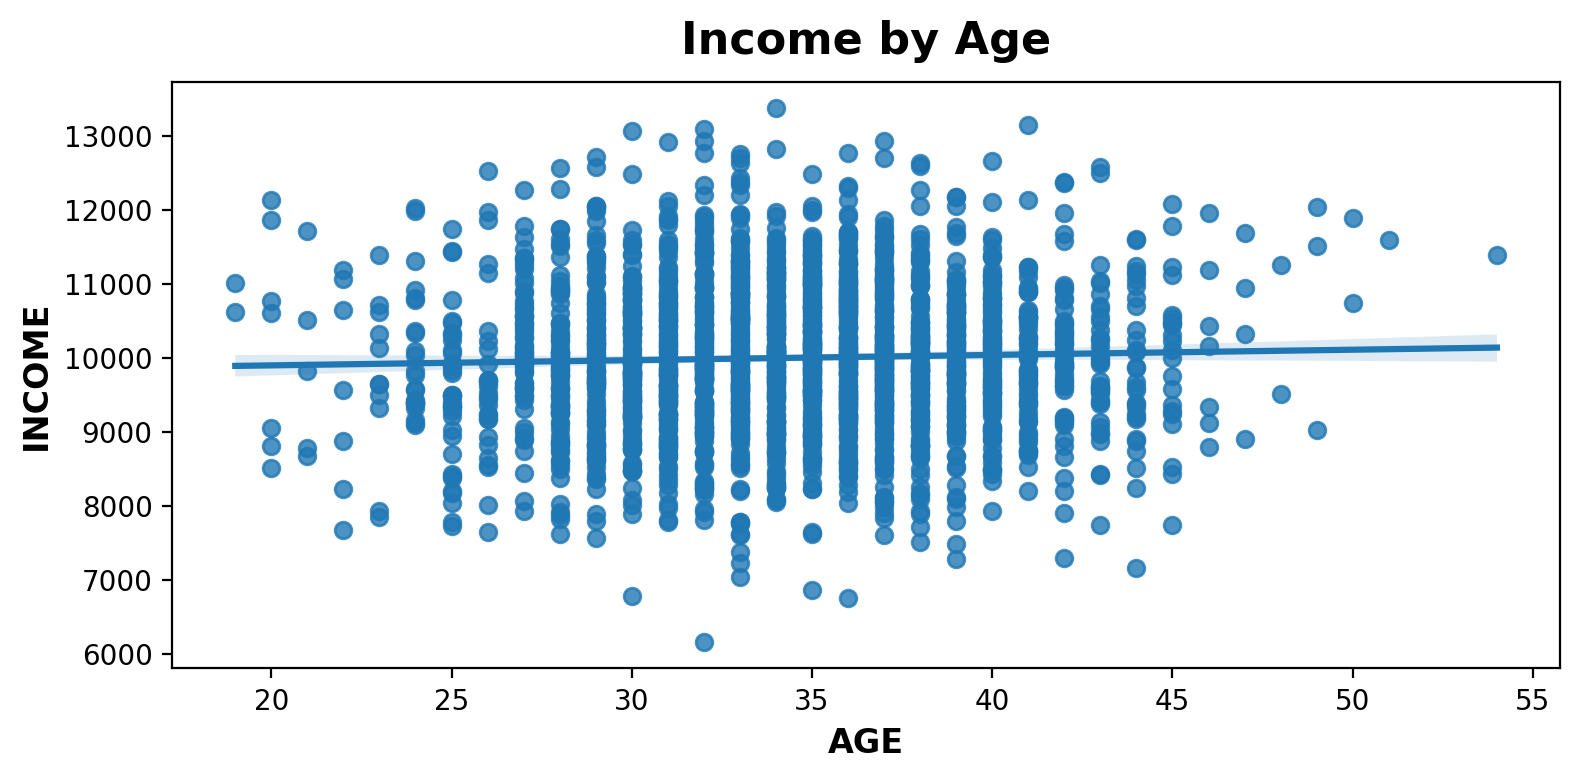

In [14]:
sns.regplot(customers, x='AGE', y='INCOME')
plt.title("Income by Age")
plt.show()

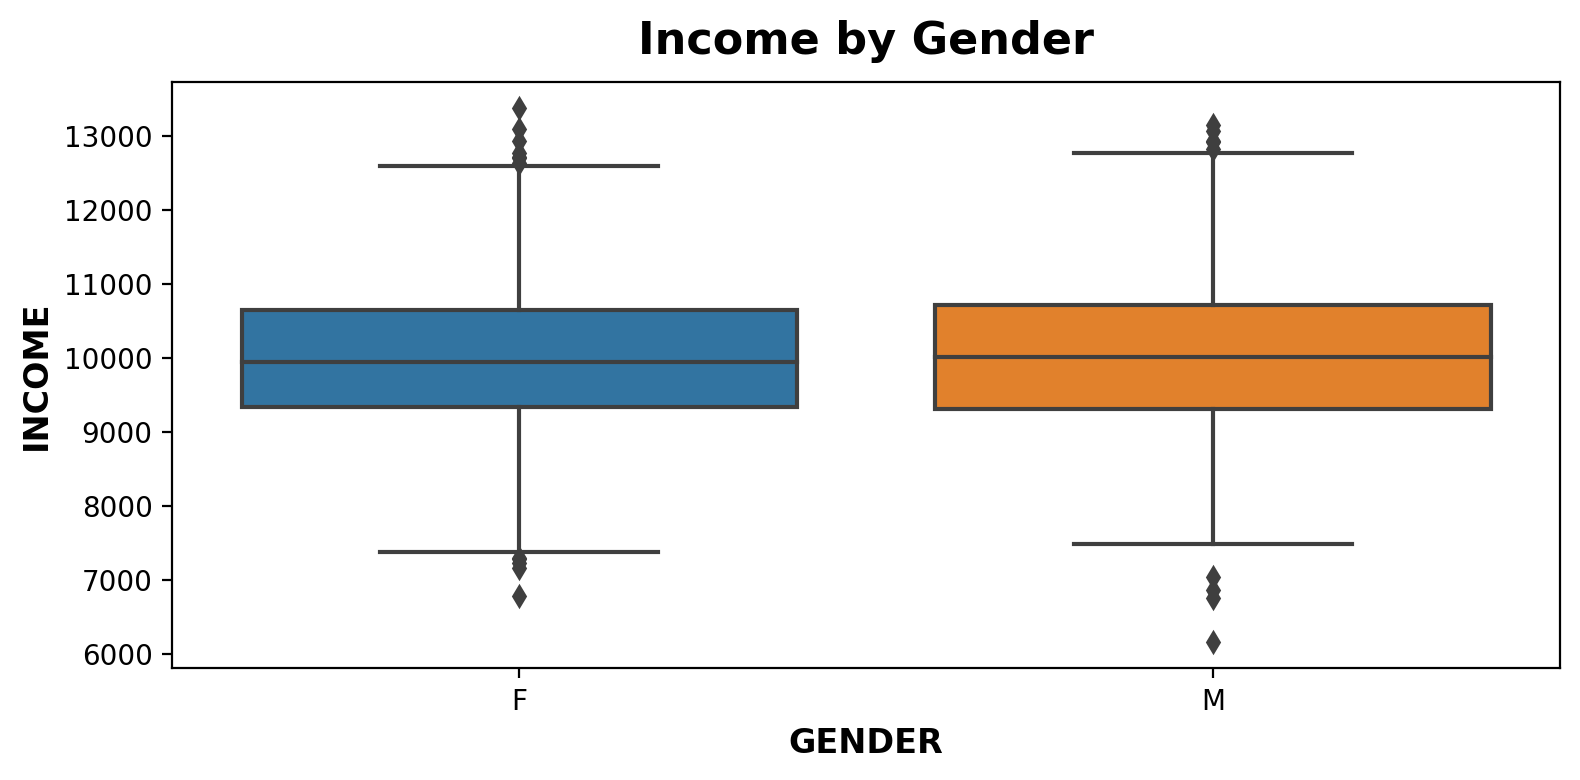

In [15]:
sns.boxplot(customers, x='GENDER', y='INCOME')
plt.title("Income by Gender")
plt.show()

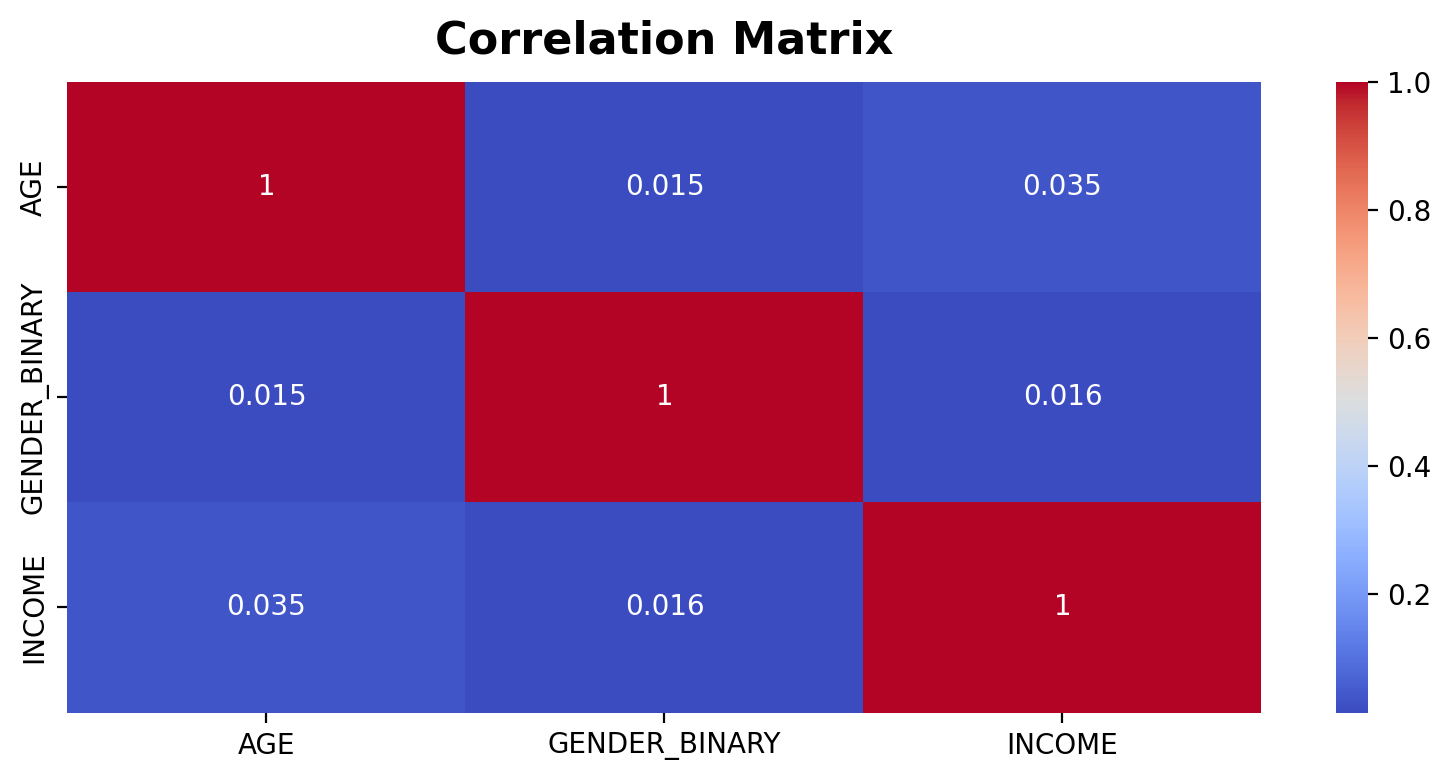

In [16]:
customers['GENDER_BINARY'] = customers['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
corr_matrix = customers[['AGE', 'GENDER_BINARY', 'INCOME']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

There is a slight upward trend in INCOME as AGE increases, but I wouldn't say there's much correlation between any of these features. Without knowing for sure what is behind these null values, the safest thing to do would be to drop the rows containing them. Otherwise, we could shift the distribution of the data greatly (as can be seen in the next cell), and this direction might be wrong. Additionally, without knowing a person's income, we probably wouldn't want to target them with loan offers.

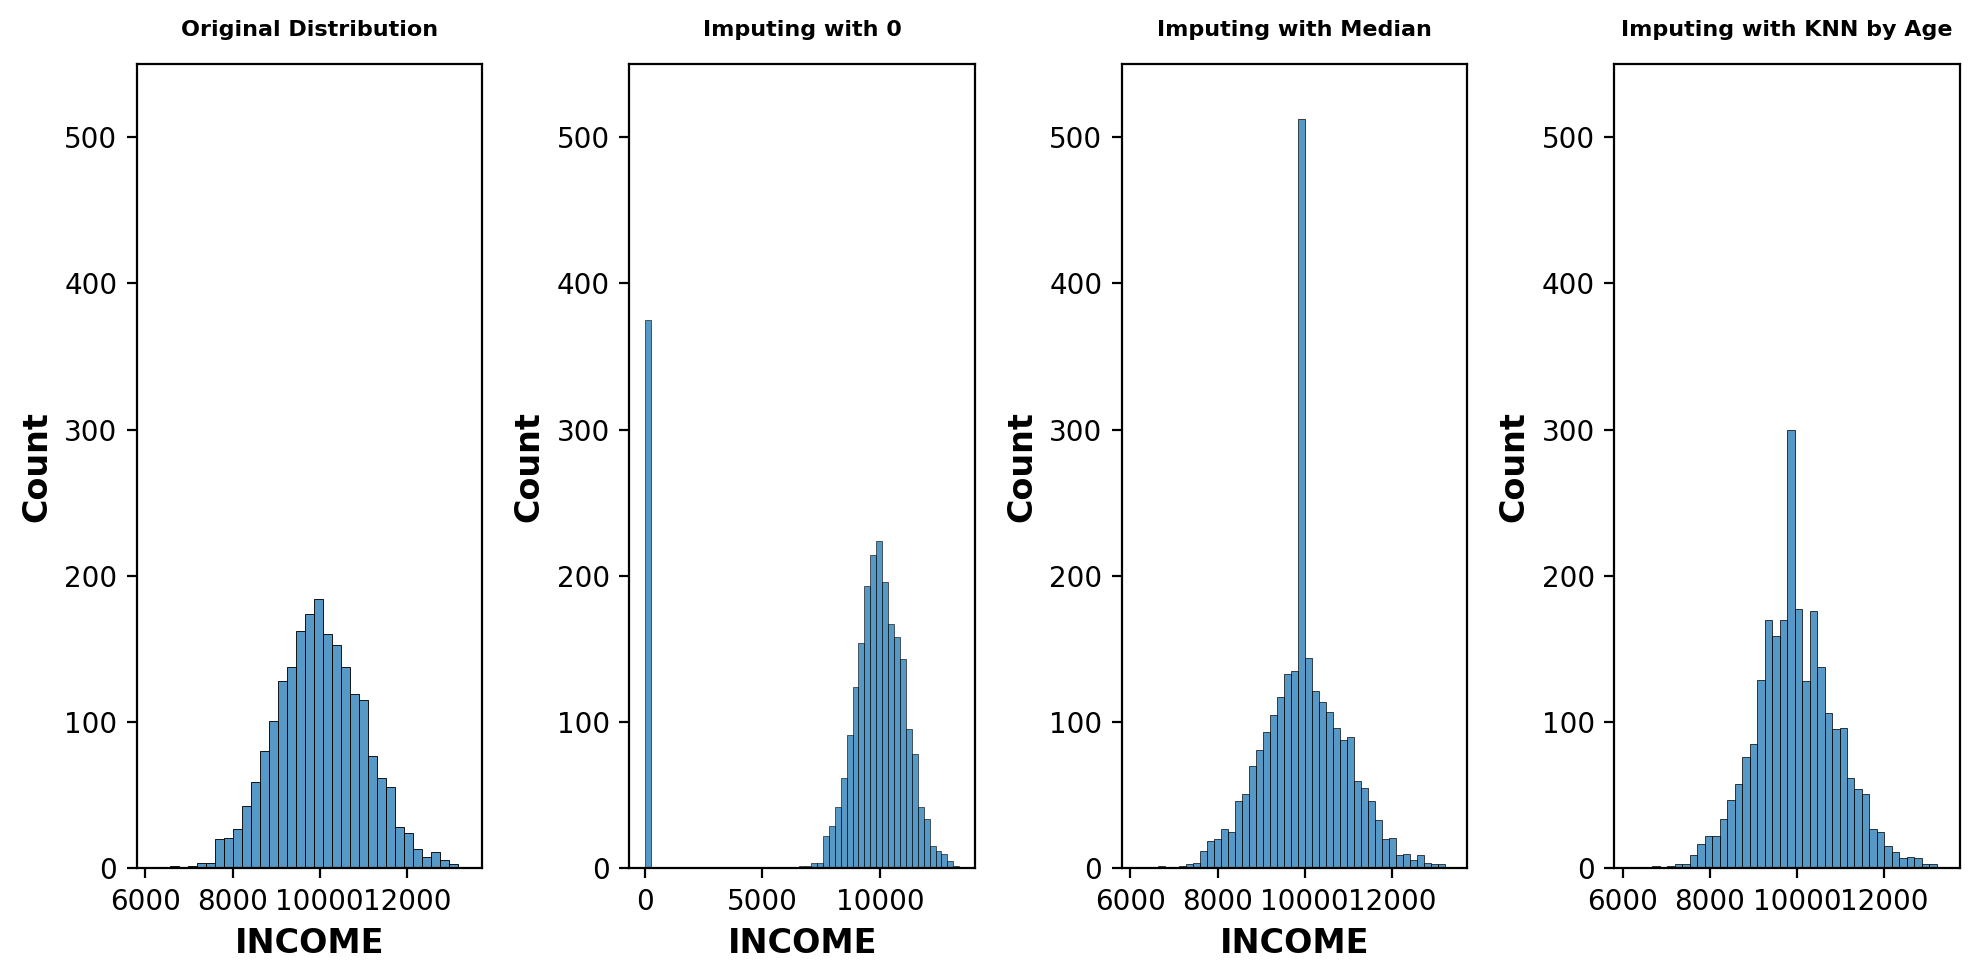

In [17]:
from sklearn.impute import KNNImputer

fig, axes = plt.subplots(1, 4, figsize=(10, 5))

sns.histplot(customers['INCOME'], ax=axes[0])
axes[0].set_title("Original Distribution", fontsize=8)
axes[0].set_ylim(0, 550)

sns.histplot(customers['INCOME'].fillna(0), ax=axes[1])
axes[1].set_title("Imputing with 0", fontsize=8)
axes[1].set_ylim(0, 550)

sns.histplot(customers['INCOME'].fillna(customers['INCOME'].median()), ax=axes[2])
axes[2].set_title("Imputing with Median", fontsize=8)
axes[2].set_ylim(0, 550)

knn_imputer = KNNImputer(n_neighbors=5)
income_knn = knn_imputer.fit_transform(customers[['AGE', 'INCOME']])[:, 1]
sns.histplot(income_knn, ax=axes[3])
axes[3].set_title("Imputing with KNN by Age", fontsize=8)
axes[3].set_ylim(0, 550)

plt.show()

Finally, let's drop the values.

In [18]:
customers = customers.dropna(subset=['INCOME'])

##### **Step 2:** 
- Analyse the `loans` dataset

Let's conduct the same analysis for the `loans` dataset.

In [19]:
loans = pd.read_parquet("loans.parquet", engine='pyarrow')

print("Shape: ", loans.shape)

loans.head()

Shape:  (3203, 4)


,ID,DATE,AMOUNT,OUTCOME
1351,LG0PC60M,2022-04-27,24415,Declined
5,YNRVXFHU,2022-01-24,24883,Declined
1437,IQIT/RIF,2022-04-16,21650,Declined
1064,ZQYTNBWX,2022-03-09,19822,Declined
1956,JZHEH32O,2022-05-15,17996,Declined


In [20]:
print("Types: ")
loans.dtypes

Types: 


ID         object
DATE       object
AMOUNT      int64
OUTCOME    object
dtype: object

In [21]:
loans['DATE'] = pd.to_datetime(loans['DATE'])

print("Types: ")
loans.dtypes

Types: 


ID                 object
DATE       datetime64[ns]
AMOUNT              int64
OUTCOME            object
dtype: object

In [22]:
print("Null values: ")
loans.isna().sum()

Null values: 


ID         0
DATE       0
AMOUNT     0
OUTCOME    0
dtype: int64

In [23]:
print("Number of duplicated rows:", loans.duplicated().sum())

print("Unique customers asking for loans:", loans['ID'].nunique())

Number of duplicated rows: 0
Unique customers asking for loans: 1348


In [24]:
loans['OUTCOME'].value_counts()

OUTCOME
Declined    2745
TakeUp       458
Name: count, dtype: int64

In [25]:
loans.describe()

,DATE,AMOUNT
count,3203,3203.000000
mean,2022-05-17 19:22:36.603184640,20102.640649
min,2022-01-02 00:00:00,7475.000000
25%,2022-03-27 00:00:00,17550.500000
50%,2022-05-21 00:00:00,19936.000000
75%,2022-07-12 00:00:00,22542.000000
max,2022-08-30 00:00:00,33205.000000
std,NaN,3650.680235


Everything seems valid for now. Here we can also note that we have 8 months of loan requests history. Let's visualise all the request outcomes throughout the history.

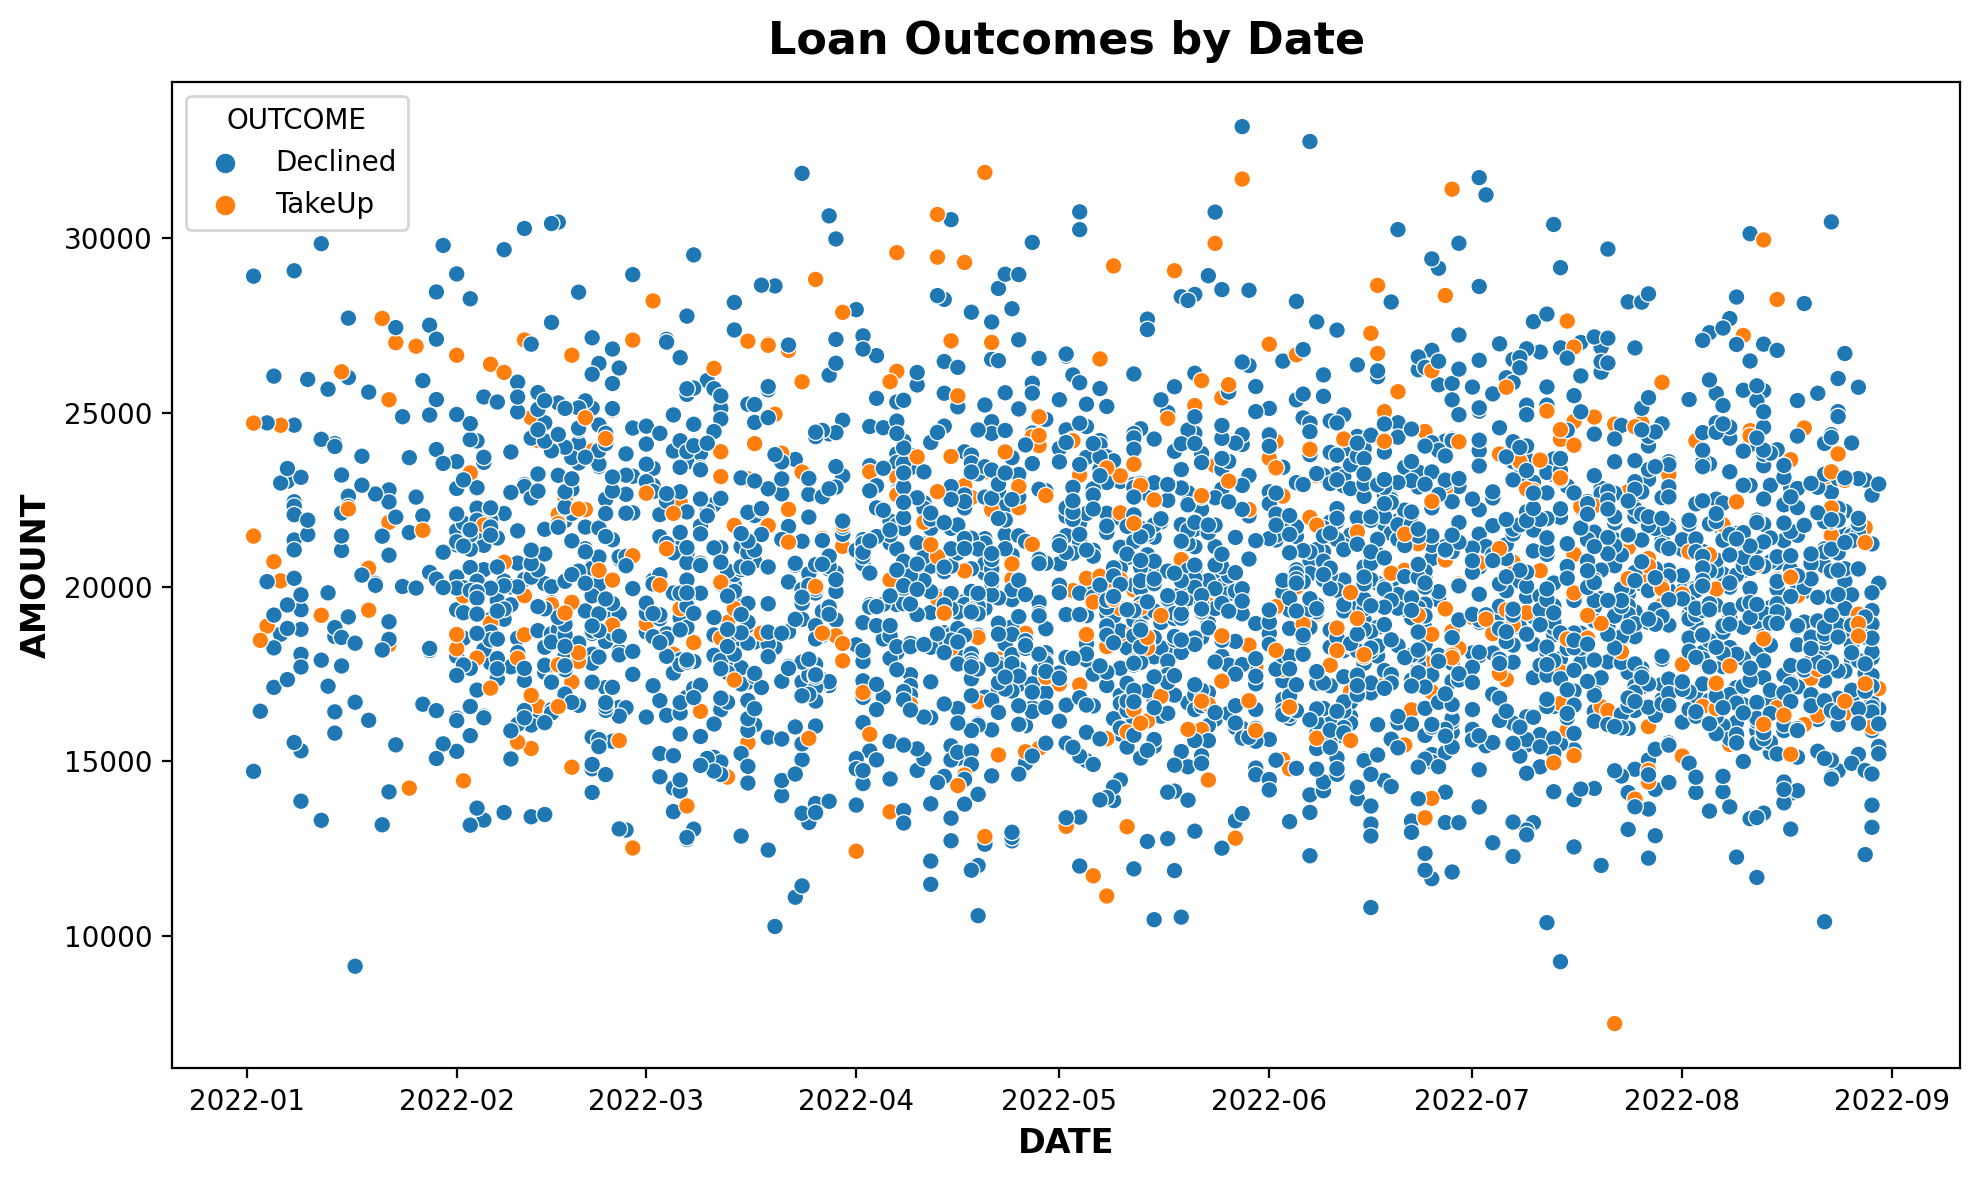

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(loans, x='DATE', y='AMOUNT', hue='OUTCOME')
plt.title("Loan Outcomes by Date")
plt.show()

##### **Step 3:** 
- Analyse `loans`-`customers` relationship

Let's try to analyse what information about the customer could influence loan decisions.

In [27]:
loans_before_july_customers = pd.merge(loans, customers, on='ID', how='left')
loans_before_july_customers.head()

,ID,DATE,AMOUNT,OUTCOME,GENDER,AGE,INCOME,GENDER_BINARY
0,LG0PC60M,2022-04-27,24415,Declined,M,31.0,10830.0,1.0
1,YNRVXFHU,2022-01-24,24883,Declined,M,41.0,13157.0,1.0
2,IQIT/RIF,2022-04-16,21650,Declined,M,35.0,9799.0,1.0
3,ZQYTNBWX,2022-03-09,19822,Declined,M,33.0,11378.0,1.0
4,JZHEH32O,2022-05-15,17996,Declined,M,38.0,9822.0,1.0


In [28]:
loans_before_july_customers.isna().sum()

ID                 0
DATE               0
AMOUNT             0
OUTCOME            0
GENDER           470
AGE              470
INCOME           470
GENDER_BINARY    470
dtype: int64

In [29]:
# These are the loans for the customers with null INCOME value which we dropped. Let's also drop these rows.
loans_before_july_customers = loans_before_july_customers.dropna()

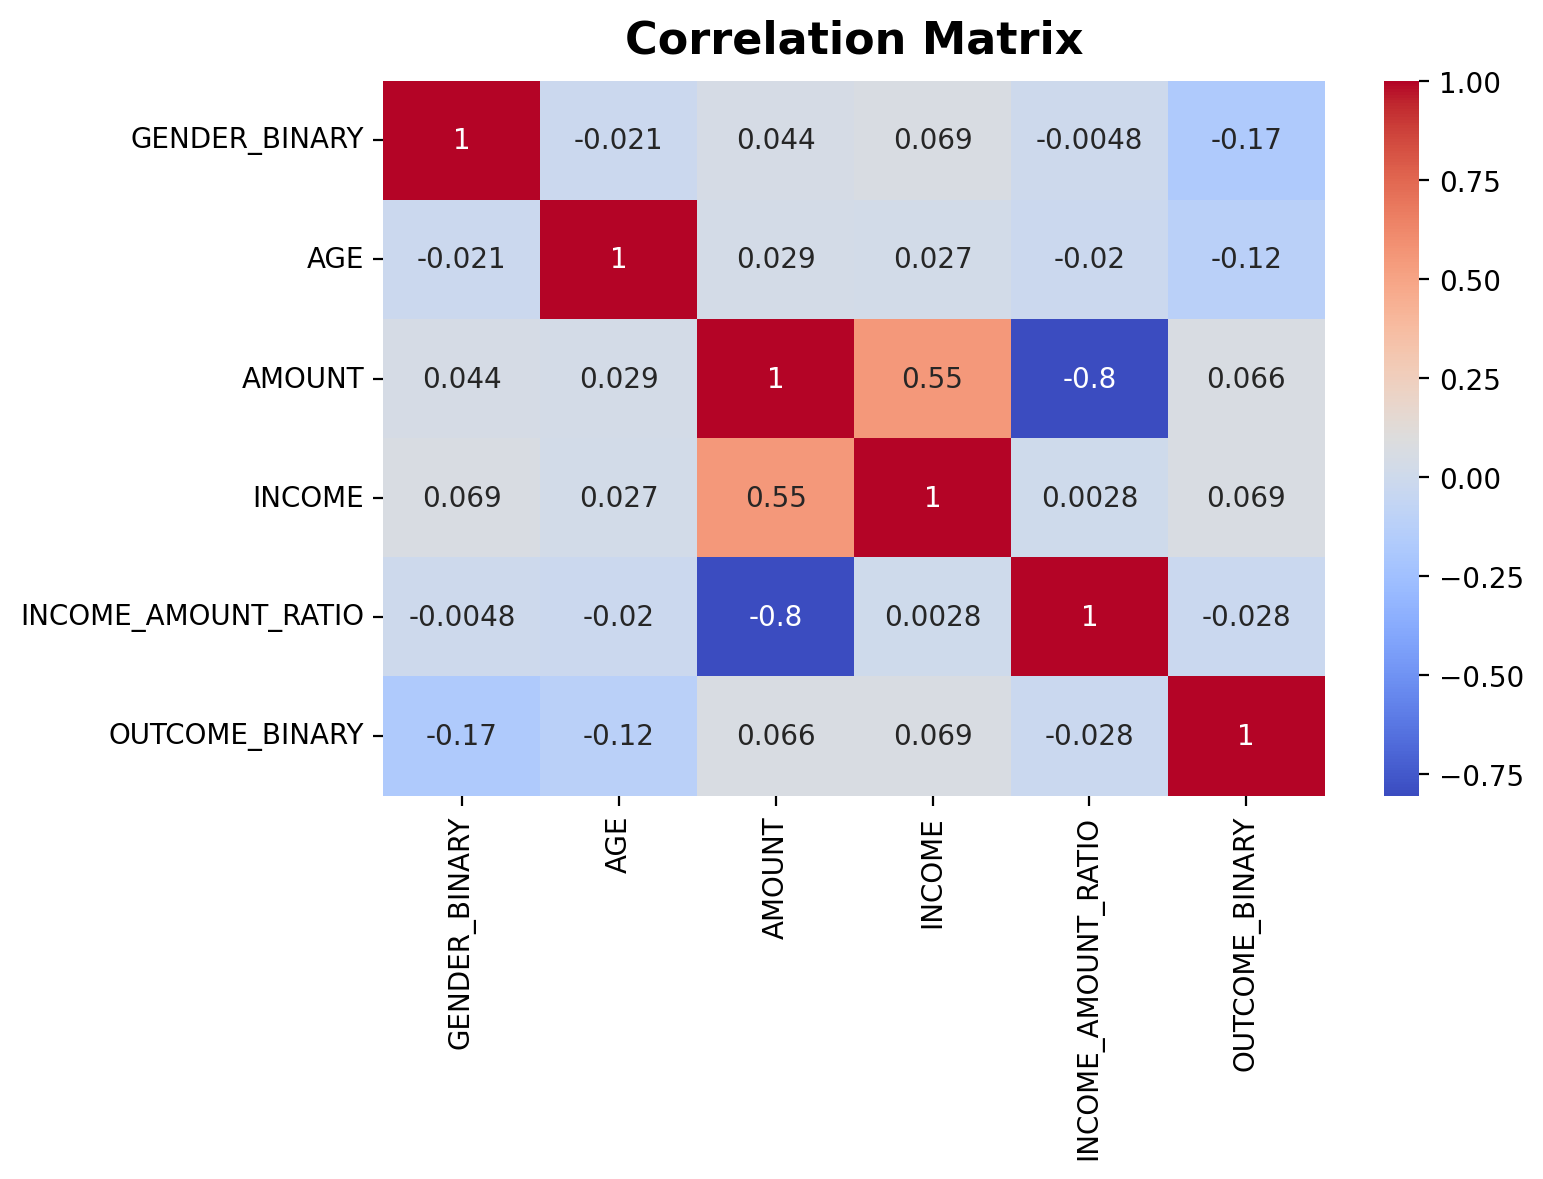

In [30]:
loans_before_july_customers['OUTCOME_BINARY'] = loans_before_july_customers['OUTCOME'].apply(lambda x: 1 if x == 'TakeUp' else 0)

# We can also calculate some other features which might be informative
loans_before_july_customers['INCOME_AMOUNT_RATIO'] = loans_before_july_customers['INCOME'] / loans_before_july_customers['AMOUNT']

corr_matrix = loans_before_july_customers[
    ['GENDER_BINARY', 'AGE', 'AMOUNT', 'INCOME', 'INCOME_AMOUNT_RATIO', 'OUTCOME_BINARY']
].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

We see a strong correlation between the outcome and gender, a lower correlation with age, and some small correlation with the amount requested and the income of a customer. Let's visualise it.

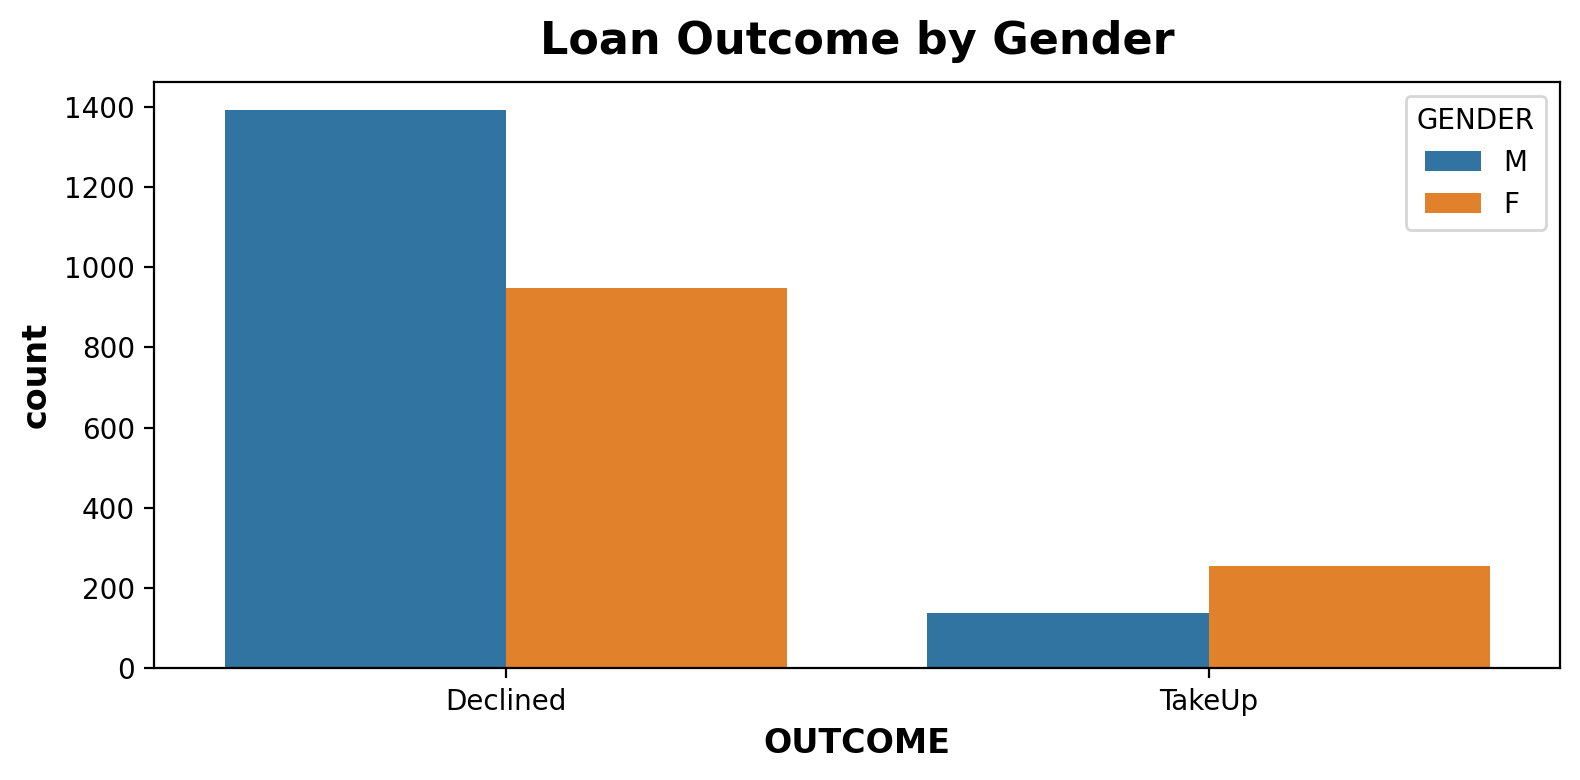

In [31]:
sns.countplot(loans_before_july_customers, x='OUTCOME', hue='GENDER')
plt.title("Loan Outcome by Gender")
plt.show()

We can see that women get approved almost twice as often as men and get declined less often than men.

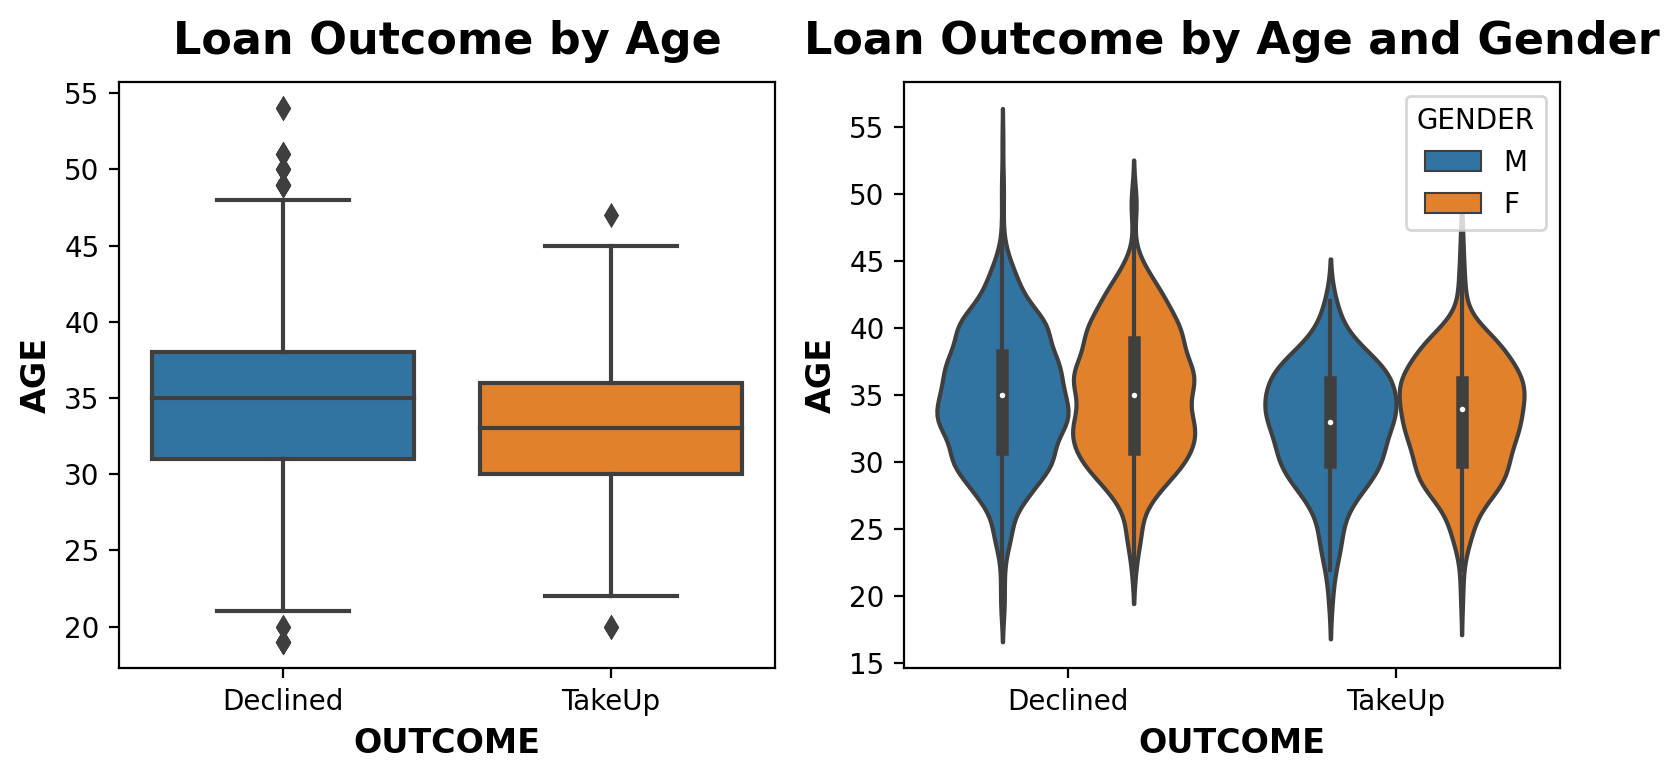

In [32]:
fig, axes = plt.subplots(1, 2)
sns.boxplot(x='OUTCOME', y='AGE', data=loans_before_july_customers, ax=axes[0])
axes[0].set_title("Loan Outcome by Age")

# Check that the correlation with AGE isn't caused by the correlation with GENDER 
# which could happen in case we had women younger than men on average
sns.violinplot(x='OUTCOME', y='AGE', data=loans_before_july_customers, hue='GENDER', ax=axes[1])
axes[1].set_title("Loan Outcome by Age and Gender")

plt.show()

We see that younger customers have a slightly higher chance of approval.

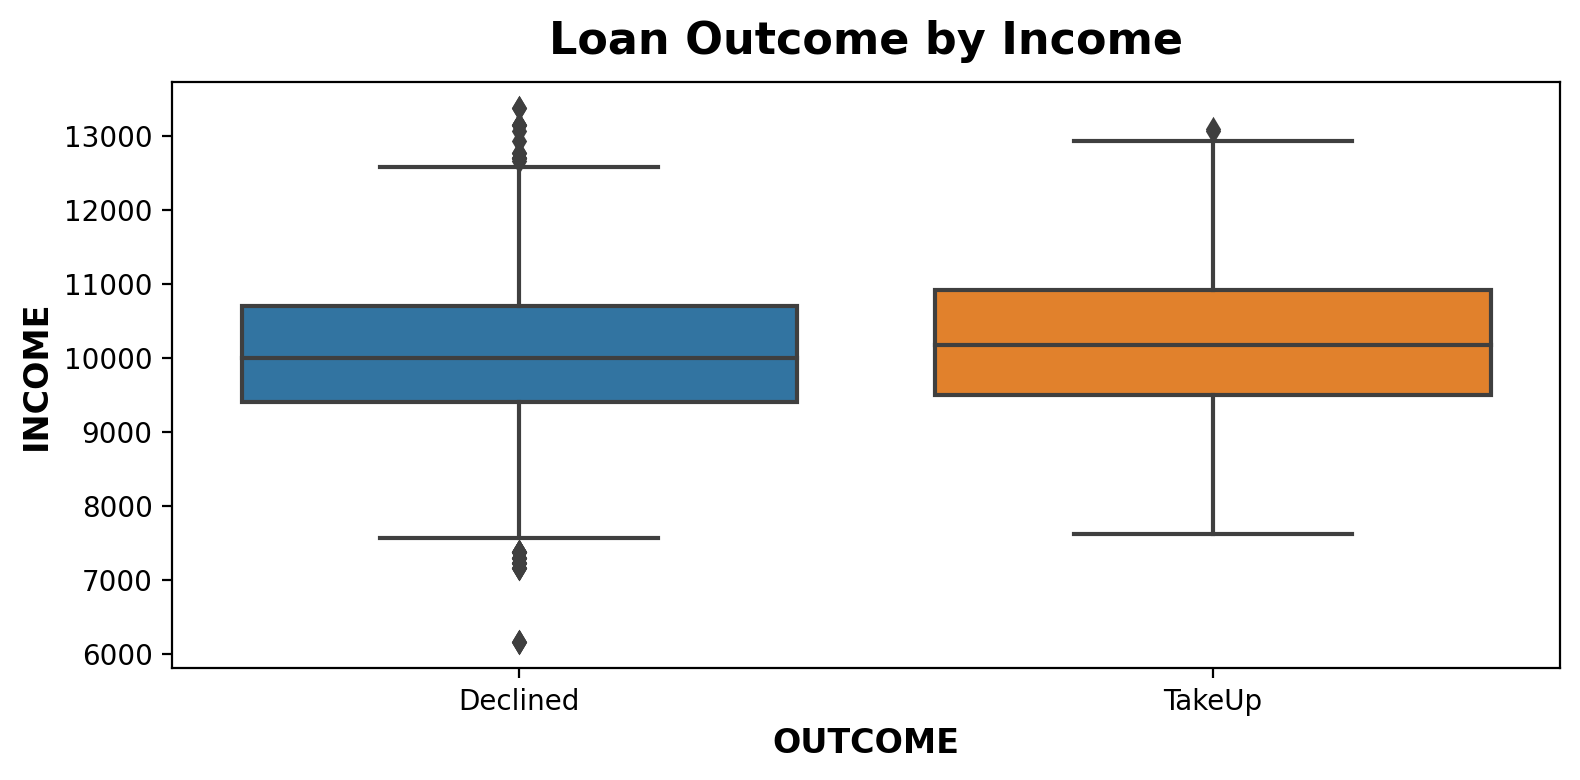

In [33]:
sns.boxplot(loans_before_july_customers, x='OUTCOME', y='INCOME')
plt.title("Loan Outcome by Income")
plt.show()

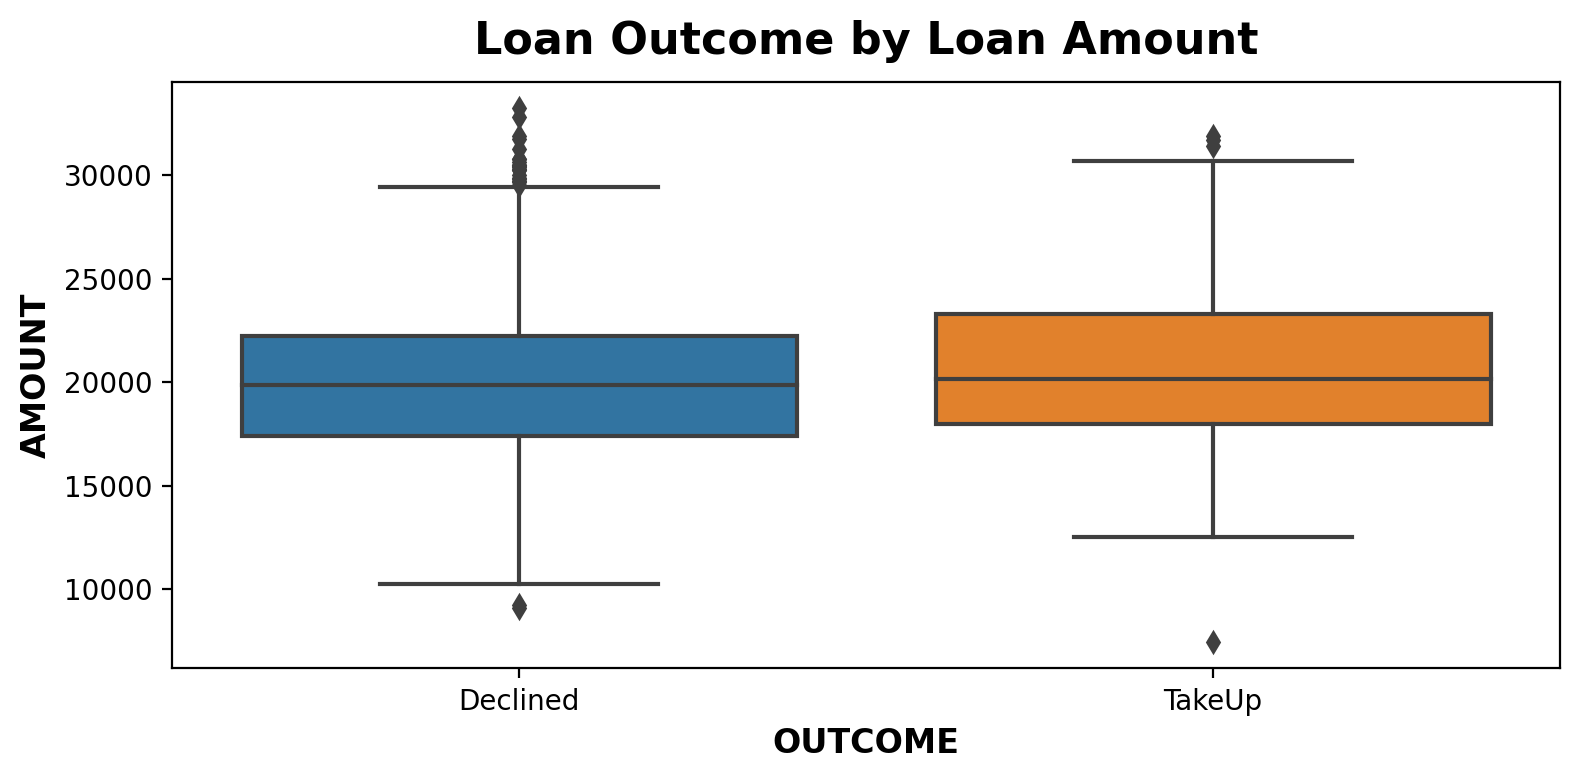

In [34]:
sns.boxplot(loans_before_july_customers, x='OUTCOME', y='AMOUNT')
plt.title("Loan Outcome by Loan Amount")
plt.show()


Last two correlations seem to be very small.

So, is there discrimination based on the gender or age? It's possible, but let's not draw any certain conclusions yet. These correlations might be caused by other factors which are hidden from us yet. For example, people of different genders or age might have different financial behaviour, and this behaviour might be the actual reason of approval or denial. Let's get back to it when we analyse the `transactions` data.

##### **Step 4:** 
- Analyse the `transactions` dataset

In [35]:
transactions = pd.read_parquet("transactions.parquet", engine='pyarrow')

print("Shape: ", transactions.shape)

transactions.head()

Shape:  (91931, 4)


,ID,DATE,AMOUNT,BALANCE
186724,HW6AIBVF,2022-07-23,-3033,17811.0
209157,JYMG2Q4S,2022-08-17,-777,8558.0
189985,BUETXTEY,2022-07-27,-501,26641.0
182248,O+AEF2OT,2022-07-18,-64,NaN
130378,TFHGRG46,2022-05-20,-1335,NaN


In [36]:
print("Types: ")
transactions.dtypes

Types: 


ID          object
DATE        object
AMOUNT       int64
BALANCE    float64
dtype: object

In [37]:
transactions['DATE'] = pd.to_datetime(transactions['DATE'])

print("Types: ")
transactions.dtypes

Types: 


ID                 object
DATE       datetime64[ns]
AMOUNT              int64
BALANCE           float64
dtype: object

In [38]:
print("Null values: ")
transactions.isna().sum()

Null values: 


ID             0
DATE           0
AMOUNT         0
BALANCE    13765
dtype: int64

In [39]:
print("Ratio of null values in BALANCE:", round(transactions['BALANCE'].isna().sum() / transactions.shape[0], 2))

transactions[transactions['BALANCE'].isna()]

Ratio of null values in BALANCE: 0.15


,ID,DATE,AMOUNT,BALANCE
182248,O+AEF2OT,2022-07-18,-64,NaN
130378,TFHGRG46,2022-05-20,-1335,NaN
145885,S5BWXB+Y,2022-06-08,-1516,NaN
218981,1MAG9XOE,2022-08-28,-592,NaN
195370,IJUCB+16,2022-08-03,-1371,NaN
...,...,...,...,...
115692,4I7QGLM+,2022-05-05,-1409,NaN
137389,VKQC1K1A,2022-05-28,-38,NaN
149035,H0YLFQTA,2022-06-12,-782,NaN
149472,WIUWYZMM,2022-06-12,-1748,NaN


In [40]:
print("Number of duplicated rows:", transactions.duplicated().sum())

Number of duplicated rows: 0


In [41]:
print("Unique clients in the transaction table:", transactions['ID'].nunique())

Unique clients in the transaction table: 2500


In [42]:
transactions.describe()

,DATE,AMOUNT,BALANCE
count,91931,91931.000000,78166.000000
mean,2022-06-30 12:20:07.218457600,56.949114,12640.257593
min,2022-05-01 00:00:00,-3456.000000,0.000000
25%,2022-05-30 00:00:00,-1297.000000,6575.000000
50%,2022-07-01 00:00:00,-933.000000,10914.000000
75%,2022-08-01 00:00:00,-545.000000,17364.750000
max,2022-08-30 00:00:00,31701.000000,56423.000000
std,NaN,3411.269696,8211.701774


Here we can note that we have 4 months of transactions history. Let's now sort the dataset and deal with the null values in the BALANCE column.

In [43]:
transactions = transactions.sort_values(by=['ID', 'DATE'])
transactions.head()

,ID,DATE,AMOUNT,BALANCE
117243,++SMIKU/,2022-05-07,-1216,4867.0
118846,++SMIKU/,2022-05-09,-1037,3830.0
121248,++SMIKU/,2022-05-12,-1025,NaN
124149,++SMIKU/,2022-05-15,9942,10114.0
128524,++SMIKU/,2022-05-19,-595,9519.0


In [44]:
transactions[transactions['ID'] == "++SMIKU/"].head(10)

,ID,DATE,AMOUNT,BALANCE
117243,++SMIKU/,2022-05-07,-1216,4867.0
118846,++SMIKU/,2022-05-09,-1037,3830.0
121248,++SMIKU/,2022-05-12,-1025,NaN
124149,++SMIKU/,2022-05-15,9942,10114.0
128524,++SMIKU/,2022-05-19,-595,9519.0
130568,++SMIKU/,2022-05-21,-574,8945.0
136642,++SMIKU/,2022-05-28,-737,NaN
138344,++SMIKU/,2022-05-30,-487,7721.0
145233,++SMIKU/,2022-06-08,-1402,6319.0
146077,++SMIKU/,2022-06-09,-877,5442.0


While the second null value in BALANCE suggests that we can infer it by adding the AMOUNT value to the previous BALANCE value (`8945 - 737 - 487 = 7721`), the first null value proves that it's not always true (`3830 - 1025 + 9942 != 10114`). However, it's the closest we can get, so we will go with this approach. We can achieve the needed calculation by shifting the BALANCE column and adding the AMOUNT column to it, taking these columns separately for each customer (using grouping) so that we don't get previous customer's balance mixed with the current customer amount when shifting the balance.

In [45]:
transactions['BALANCE_IMPUTED'] = transactions.groupby('ID')['BALANCE'].shift(1) + transactions['AMOUNT']
transactions.head()

,ID,DATE,AMOUNT,BALANCE,BALANCE_IMPUTED
117243,++SMIKU/,2022-05-07,-1216,4867.0,NaN
118846,++SMIKU/,2022-05-09,-1037,3830.0,3830.0
121248,++SMIKU/,2022-05-12,-1025,NaN,2805.0
124149,++SMIKU/,2022-05-15,9942,10114.0,NaN
128524,++SMIKU/,2022-05-19,-595,9519.0,9519.0


In [46]:
transactions['BALANCE_IMPUTED'] = transactions['BALANCE'].fillna(transactions['BALANCE_IMPUTED'])

In [47]:
transactions.isna().sum()

ID                     0
DATE                   0
AMOUNT                 0
BALANCE            13765
BALANCE_IMPUTED     2367
dtype: int64

In cases where we had several null values in a row, we weren't able to infer them by shifting and adding, so let's just drop them (they take up only 2% of the dataset).

In [48]:
transactions = transactions.dropna(subset=['BALANCE_IMPUTED'])

In [49]:
transactions.describe()

,DATE,AMOUNT,BALANCE,BALANCE_IMPUTED
count,89564,89564.00000,78166.000000,89564.000000
mean,2022-06-30 16:28:07.856728064,61.71627,12640.257593,12660.139554
min,2022-05-01 00:00:00,-3456.00000,0.000000,-1544.000000
25%,2022-06-01 00:00:00,-1297.00000,6575.000000,6552.000000
50%,2022-07-01 00:00:00,-932.00000,10914.000000,10940.000000
75%,2022-08-01 00:00:00,-545.00000,17364.750000,17425.250000
max,2022-08-30 00:00:00,31701.00000,56423.000000,58191.000000
std,NaN,3417.03149,8211.701774,8243.964318


We should notice here that we introduced some negative balances, which happened in cases where the balance minus the transaction amount resulted in negative balance and was marked as NaN in the original dataset. We can leave them be, they shouldn't cause us any troubles in the future.

##### **Step 5:** 
- Prepare the dataset for training
- Check if the transaction data could address concerns about discrimination

Let's think what we can use to predict if a customer needs a loan. First of all, we have a dataset with loan requests, so customers in that dataset can serve as `loan_needed=1` target. The reasons why they needed a loan could be found in the `transactions` dataset, namely in the movement of their balance. We will also check if there's correlation with other features, like their gender, age, or income. People who have never asked for a loan (do not appear in the `loans` dataset) can serve as `loan_needed=0` target. 

However, since we want to use the model to predict the customers who need a loan based on their current data (e.g. balance movement in the past 2 months), we should not use this period in training. We have 4 months of transactions history, so we will train the model on the first 2 months (May, June), and then run the inference on the last 2 months (July, August).

Now, how can we describe customer's balance movement to our model? One approach is to fit a regression line to the data and use its coefficients as features for our model. Let's write a function for it.

In [50]:
def compute_balance_slope_intercept(df, transactions, loan_date=None, days_before=None):
    from sklearn.linear_model import LinearRegression
    
    balances = []
    slopes = []
    intercepts = []

    # Iterate over the dataframe rows
    for _, row in df.iterrows():
        customer_id = row['ID']

        if loan_date:
            # Subtract days_before days from the loan date. 
            # We do this because we don't want the data from the day when the outcome is already determined, 
            # but rather from a few days prior.
            to_date = row['DATE'] - pd.Timedelta(days=days_before)
        else:
            # For customers without loans, consider all transactions before July 1
            to_date = '2022-06-30'
        
        # Filter transactions for the same customer up to `to_date`
        past_transactions = transactions[(transactions['ID'] == customer_id) & (transactions['DATE'] <= to_date)]
        
        if not past_transactions.empty:
            # Get the last balance as the current balance
            balance = past_transactions.iloc[-1]['BALANCE_IMPUTED']
            
            # If there are at least two transactions, calculate the slope and intercept
            if len(past_transactions) >= 2:
                x = past_transactions['DATE'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
                y = past_transactions['BALANCE_IMPUTED'].values
                
                model = LinearRegression()
                model.fit(x, y)
                
                slope = model.coef_[0]
                intercept = model.intercept_
            else:
                # If not enough data points, use 0 for slope and intercept
                slope = 0
                intercept = 0
        else:
            # If no transactions, set current balance, slope, and intercept to 0
            balance = 0
            slope = 0
            intercept = 0
        
        # Append the computed values to the respective lists
        balances.append(balance)
        slopes.append(slope)
        intercepts.append(intercept)
    
    # Add the computed columns to the DataFrame
    df['BALANCE'] = np.array(balances)
    df['BALANCE_SLOPE'] = np.array(slopes)
    df['BALANCE_INTERCEPT'] = np.array(intercepts)
    
    return df

In [51]:
loans_before_july = loans[loans['DATE'] < '2022-07-01'].copy()

# Since our transaction data begins on 2022-05-01, we also want to filter loans 
# requested after the transaction history starts, plus some time for transactions to be made.
loans_before_july = loans_before_july[loans_before_july['DATE'] >= '2022-05-07']

loans_before_july = compute_balance_slope_intercept(
    loans_before_july, 
    transactions, 
    loan_date=True, 
    days_before=3
)

loans_before_july.head()

,ID,DATE,AMOUNT,OUTCOME,BALANCE,BALANCE_SLOPE,BALANCE_INTERCEPT
1956,JZHEH32O,2022-05-15,17996,Declined,1784.0,-486.130081,3.589045e+08
2722,NQ/PW1MF,2022-06-14,13924,Declined,10109.0,153.190106,-1.130938e+08
2772,DCEGETLJ,2022-06-20,24711,Declined,1217.0,-306.965513,2.266415e+08
2555,AZBXG5UR,2022-06-08,23195,TakeUp,6185.0,126.290260,-9.323478e+07
2075,HKTAE0YW,2022-05-24,20177,Declined,7701.0,402.024194,-2.968035e+08


Let's check that the regression lines are built correctly by visualising one of the examples.

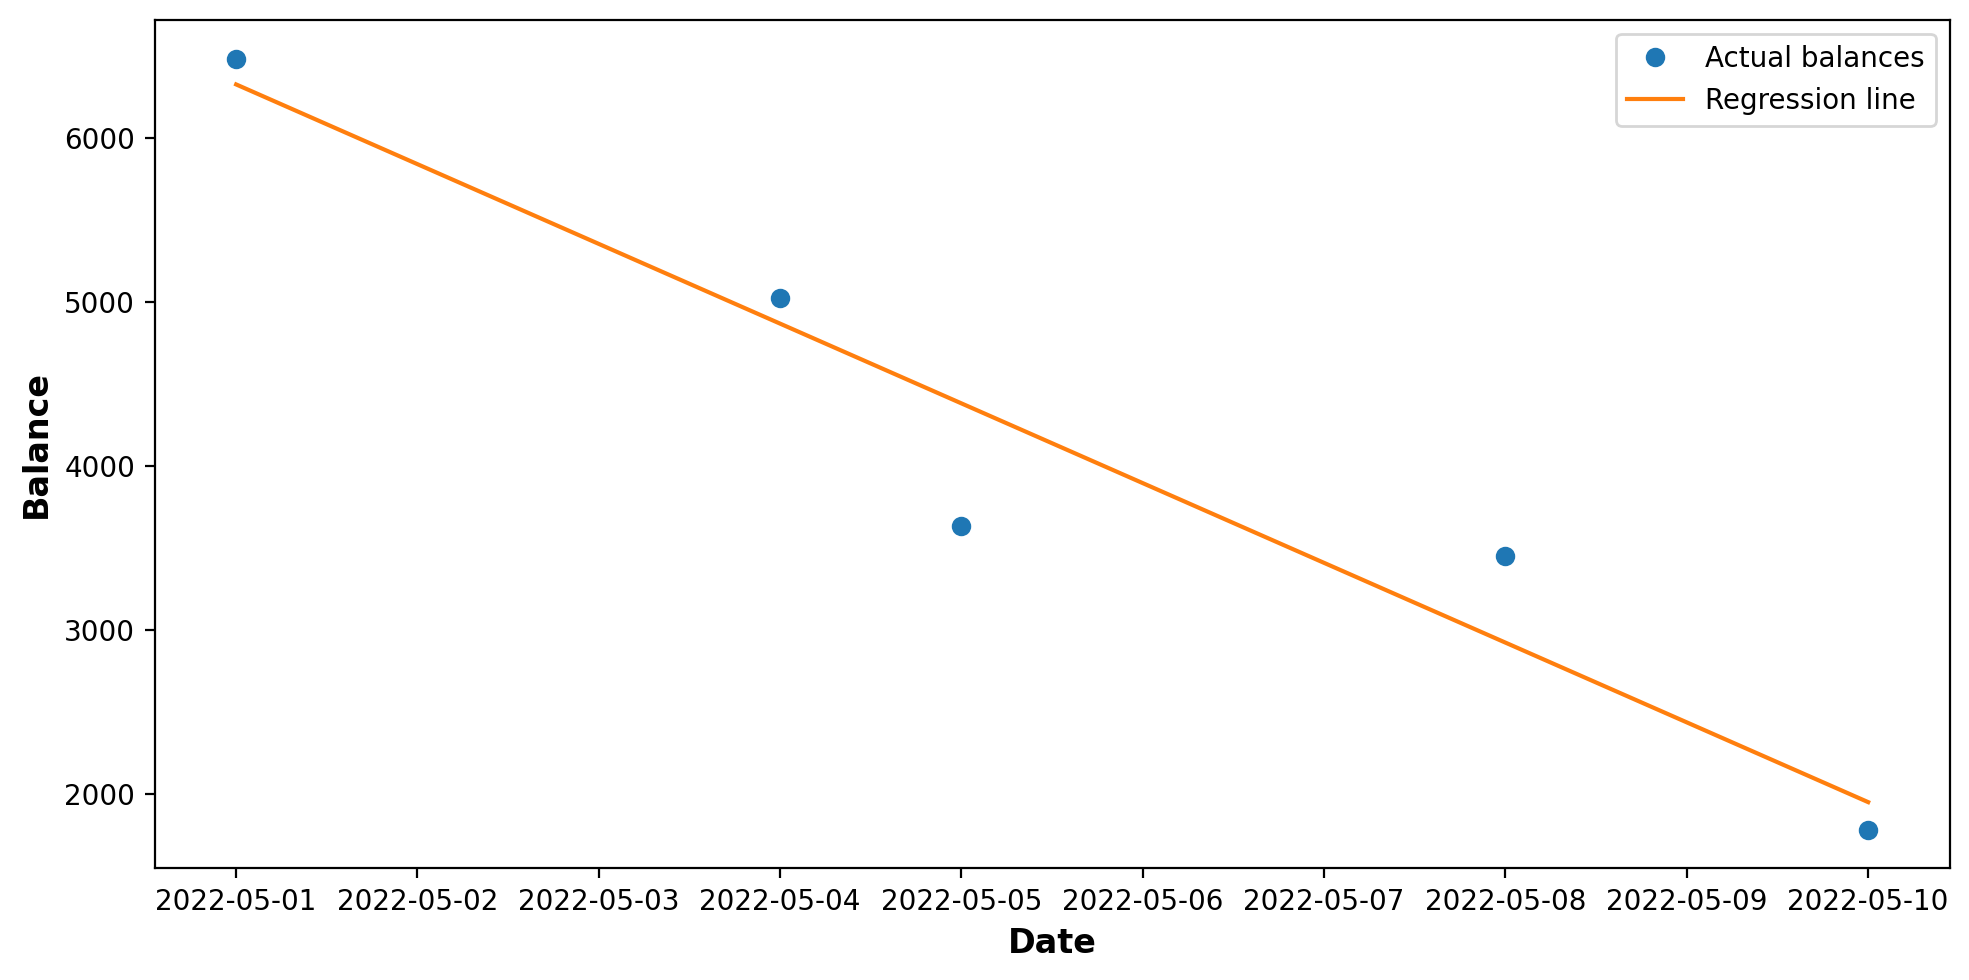

In [52]:
client_transactions = transactions[(transactions['ID'] == "JZHEH32O") & (transactions['DATE'] <= "2022-05-12")]

plt.figure(figsize=(10, 5))

# Plot the balances
plt.plot(client_transactions['DATE'], client_transactions['BALANCE'], 'o', label="Actual balances")

# Plot the calculated regression line
slope = -486.130081
intercept = 3.589045e+08
date_range = client_transactions['DATE'].map(pd.Timestamp.toordinal)
regression_line = slope * date_range + intercept

plt.plot(client_transactions['DATE'], regression_line, label="Regression line")

plt.xlabel("Date")
plt.ylabel("Balance")
plt.legend()

plt.show()

Having new features describing customers' changes in the financial situation, let's see if they could be a hidden cause of the correlation between gender / age and the loan decision.

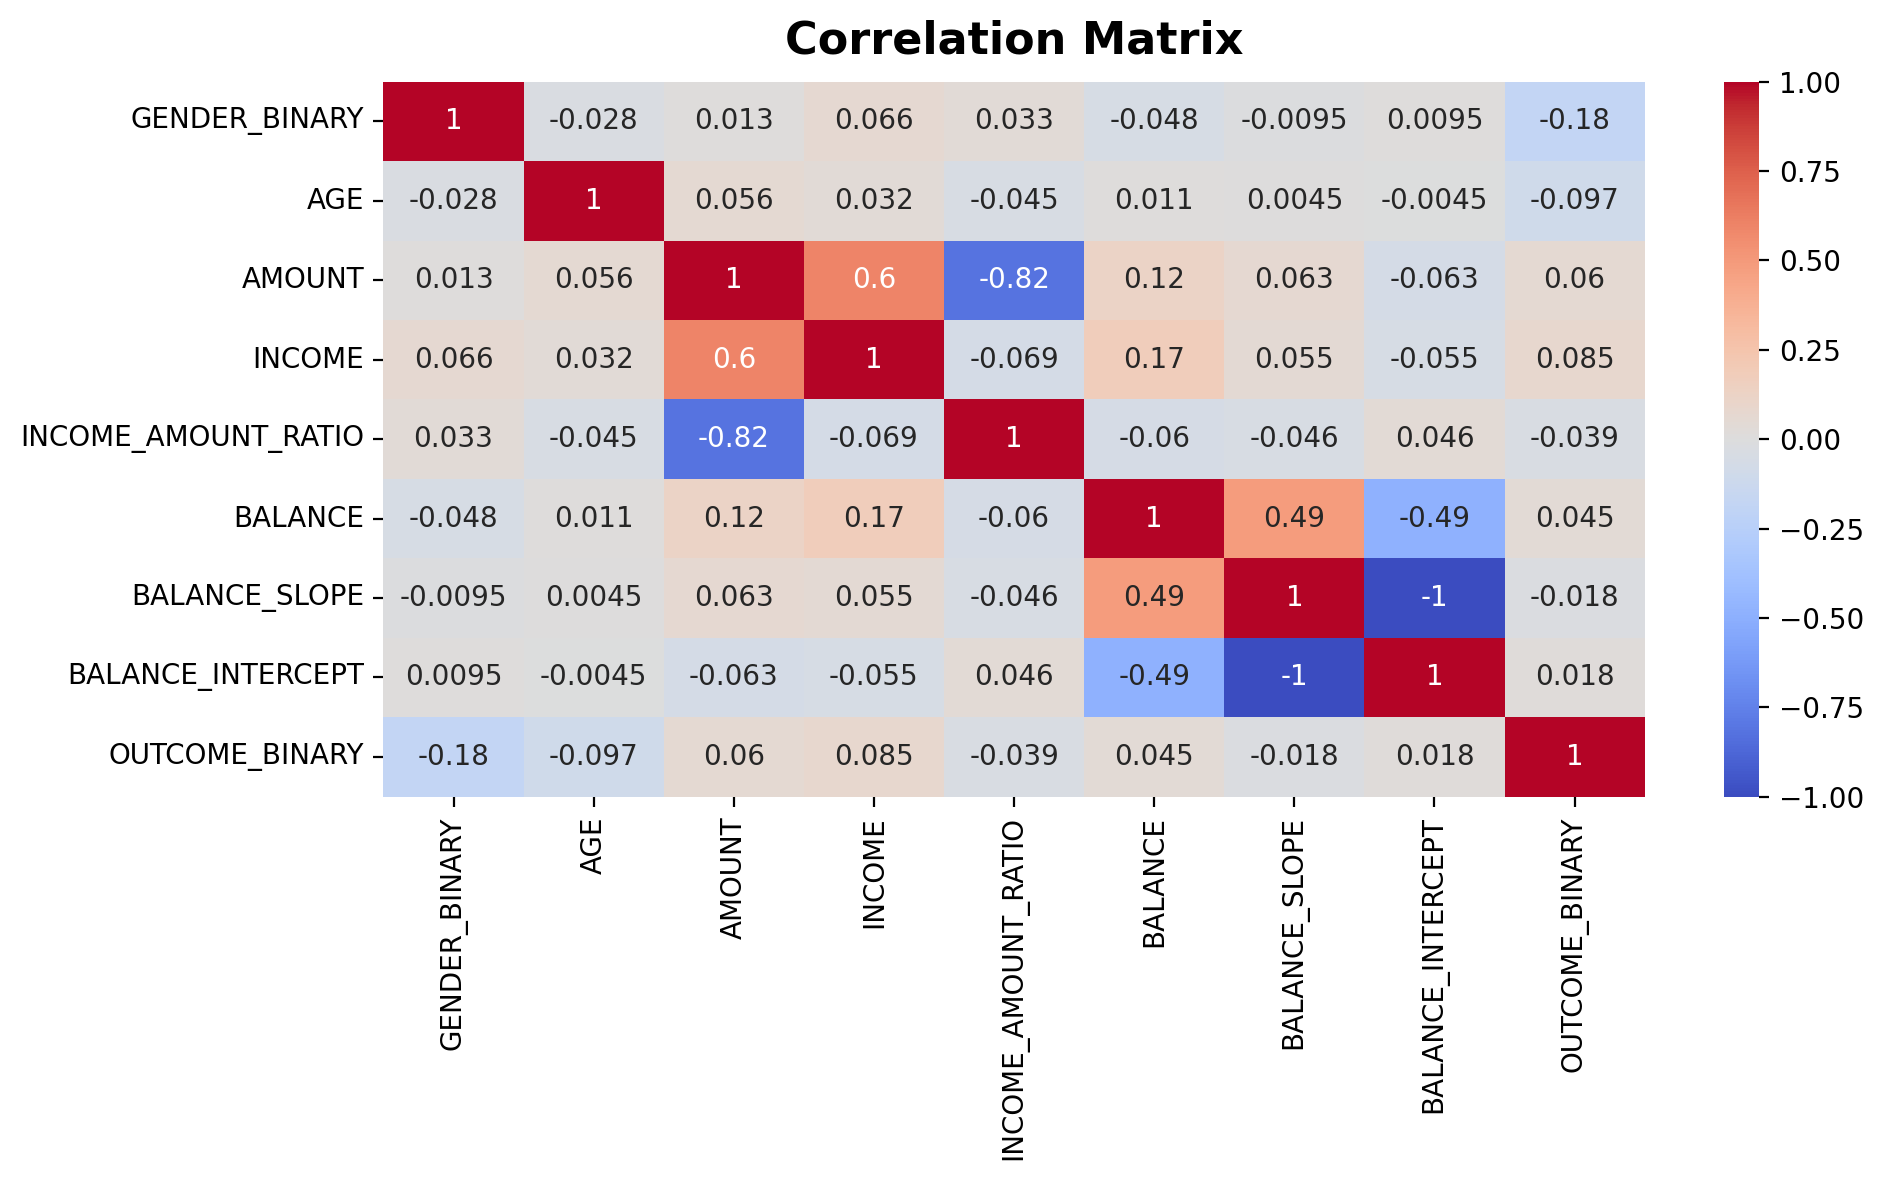

In [53]:
loans_before_july_customers = pd.merge(loans_before_july, customers, on='ID', how='left')
loans_before_july_customers['OUTCOME_BINARY'] = loans_before_july_customers['OUTCOME'].apply(lambda x: 1 if x == 'TakeUp' else 0)
loans_before_july_customers['INCOME_AMOUNT_RATIO'] = loans_before_july_customers['INCOME'] / loans_before_july_customers['AMOUNT']

corr_matrix = loans_before_july_customers[
    ['GENDER_BINARY', 'AGE', 'AMOUNT', 'INCOME', 'INCOME_AMOUNT_RATIO', 
     'BALANCE', 'BALANCE_SLOPE', 'BALANCE_INTERCEPT', 'OUTCOME_BINARY']
].corr()


plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

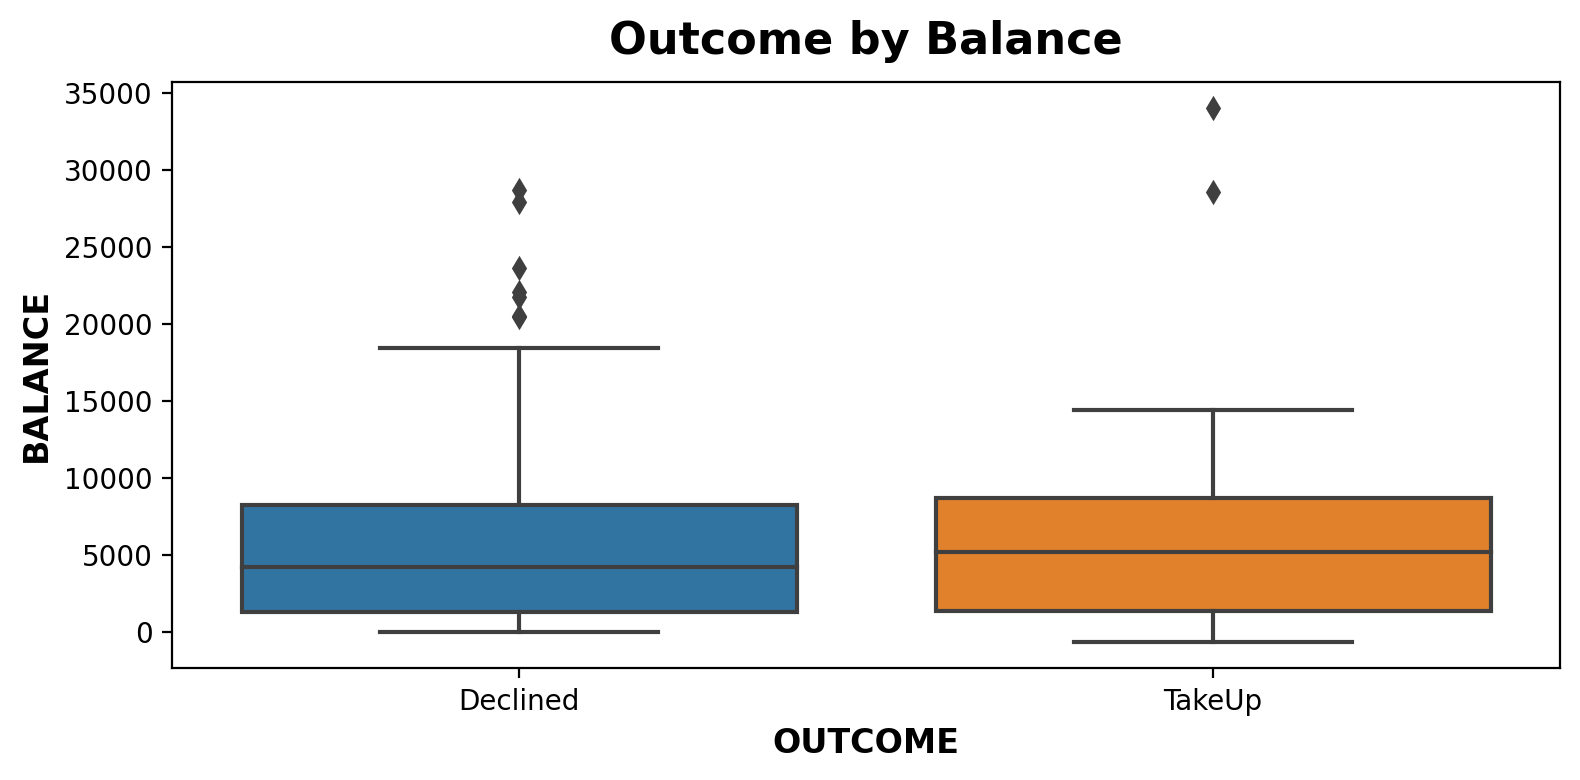

In [54]:
sns.boxplot(loans_before_july_customers, x='OUTCOME', y='BALANCE')
plt.title("Outcome by Balance")
plt.show()

Unfortunately, the current balance and balance movement before the loan decision could not justify the outcome of the decision, which makes our discrimination concerns a bit more reasonable.

Let's continue building our training dataset. First of all, we will fill it with customers who asked for a loan (before July 1).

In [55]:
train_1_df = loans_before_july_customers[['BALANCE', 'BALANCE_SLOPE', 'BALANCE_INTERCEPT', 'GENDER_BINARY', 'AGE', 'INCOME']].copy()
train_1_df = train_1_df.dropna()

train_1_df['LOAN_NEEDED'] = 1
train_1_df.head()

,BALANCE,BALANCE_SLOPE,BALANCE_INTERCEPT,GENDER_BINARY,AGE,INCOME,LOAN_NEEDED
0,1784.0,-486.130081,3.589045e+08,1.0,38.0,9822.0,1
1,10109.0,153.190106,-1.130938e+08,0.0,36.0,9358.0,1
2,1217.0,-306.965513,2.266415e+08,0.0,45.0,11787.0,1
3,6185.0,126.290260,-9.323478e+07,1.0,31.0,10658.0,1
4,7701.0,402.024194,-2.968035e+08,0.0,30.0,8843.0,1


Now let's collect customers who haven't ever asked for a loan by July 1.

In [56]:
customers['LOAN_WAS_NEEDED'] = customers['ID'].isin(loans['ID'].values)
customers.head()

,ID,GENDER,AGE,INCOME,GENDER_BINARY,LOAN_WAS_NEEDED
0,M5FQZHG1,F,37,10843.0,0,True
1,JPOALDTW,M,38,9419.0,1,False
2,QHJXRE6A,M,37,10850.0,1,True
3,LKS17XRW,M,35,10107.0,1,True
4,V5UPOIAW,F,34,10323.0,0,True


In [57]:
customers_without_loans = customers[customers['LOAN_WAS_NEEDED'] == False].copy()

customers_without_loans = compute_balance_slope_intercept(
    customers_without_loans, 
    transactions, 
    loan_date=False, 
    days_before=None
)

customers_without_loans.head()

,ID,GENDER,AGE,INCOME,GENDER_BINARY,LOAN_WAS_NEEDED,BALANCE,BALANCE_SLOPE,BALANCE_INTERCEPT
1,JPOALDTW,M,38,9419.0,1,False,15908.0,9.439090,-6.955058e+06
9,7VWYCGWY,M,20,8805.0,1,False,10106.0,-59.031457,4.359323e+07
11,UTHARWH7,M,35,9966.0,1,False,19562.0,55.964231,-4.129932e+07
13,VXVT7SBC,F,33,10881.0,0,False,7695.0,154.875689,-1.143374e+08
14,8/G9K1DJ,F,40,10395.0,0,False,16439.0,130.750205,-9.651581e+07


In [58]:
customers_without_loans['LOAN_NEEDED'] = 0
customers_without_loans['GENDER_BINARY'] = customers_without_loans['GENDER'].apply(lambda x: 1 if x == 'M' else 0)

train_0_df = customers_without_loans[train_1_df.columns].copy()
train_0_df.head()

,BALANCE,BALANCE_SLOPE,BALANCE_INTERCEPT,GENDER_BINARY,AGE,INCOME,LOAN_NEEDED
1,15908.0,9.439090,-6.955058e+06,1,38,9419.0,0
9,10106.0,-59.031457,4.359323e+07,1,20,8805.0,0
11,19562.0,55.964231,-4.129932e+07,1,35,9966.0,0
13,7695.0,154.875689,-1.143374e+08,0,33,10881.0,0
14,16439.0,130.750205,-9.651581e+07,0,40,10395.0,0


Finally, we will combine the data into one training dataset.

In [59]:
# Check if the data is balanced
print("Rows in train_1_df:", len(train_1_df))
print("Rows in train_0_df:", len(train_0_df))

Rows in train_1_df: 744
Rows in train_0_df: 979


In [60]:
train_df = pd.concat([train_1_df, train_0_df], axis=0)

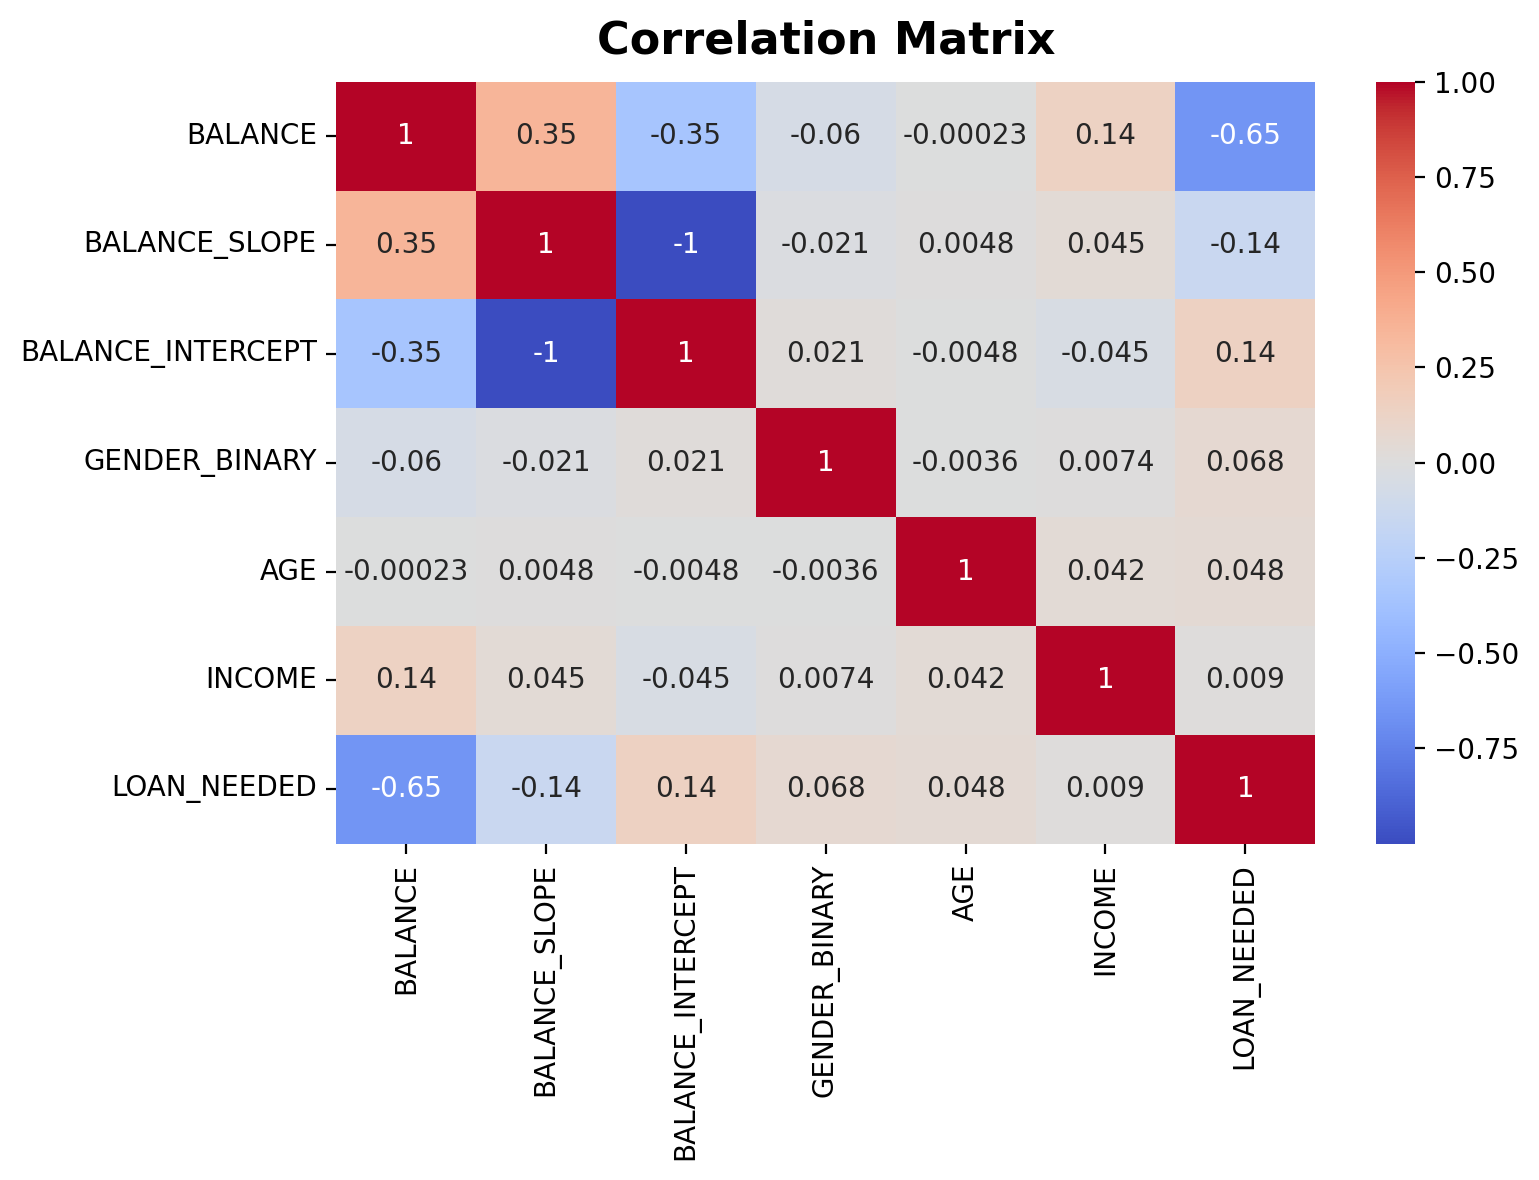

In [61]:
corr_matrix = train_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

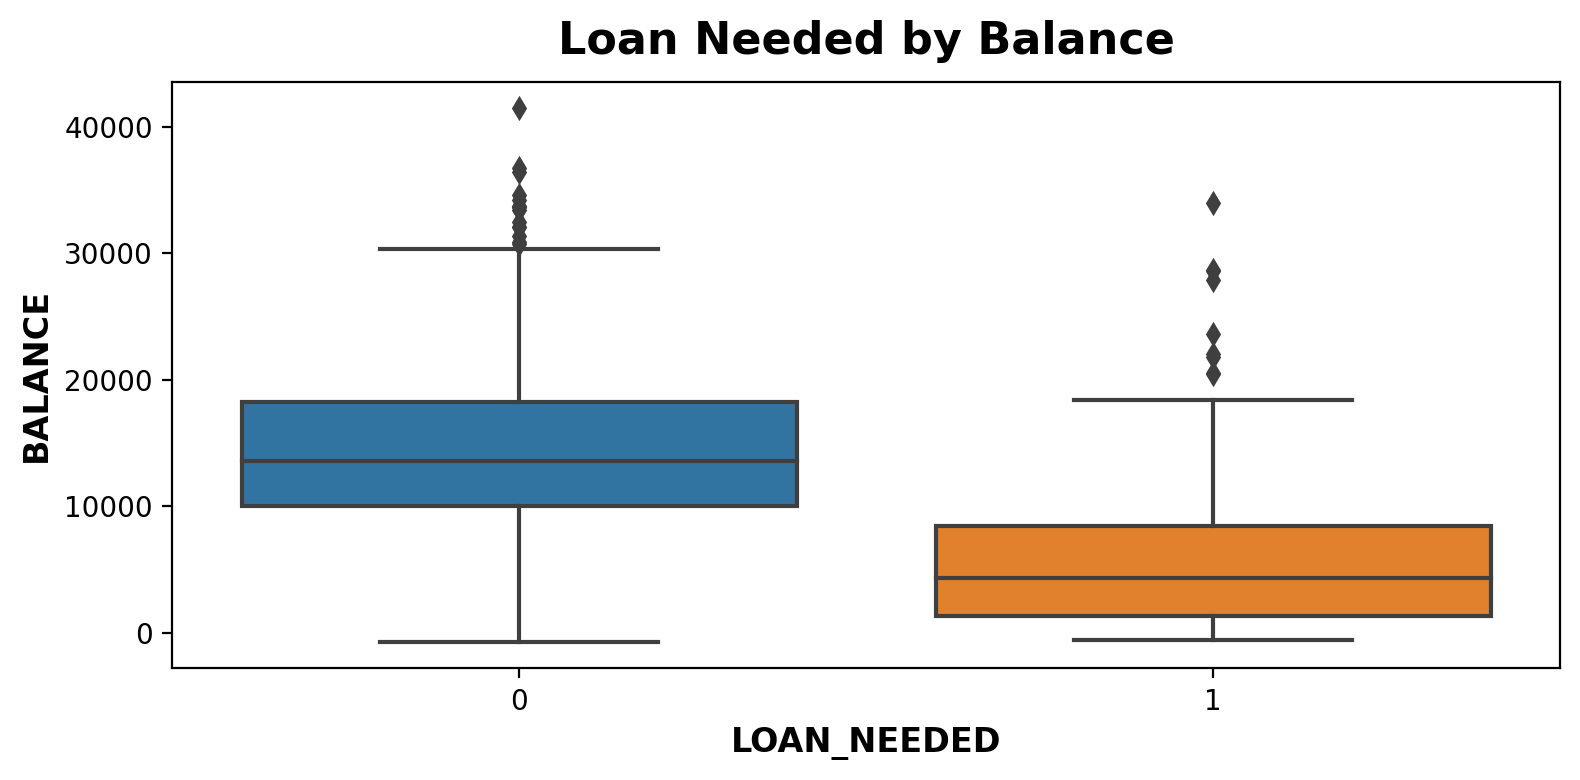

In [62]:
sns.boxplot(train_df, x='LOAN_NEEDED', y='BALANCE')
plt.title("Loan Needed by Balance")
plt.show()

Great, there is clear correlation between the customer's current balance and his need for a loan, and some smaller correlations for our other features (e.g., a negative slope of the regression line, which is a sign of a downward balance movement, increases the chances that the customer needs a loan, as can be seen in a negative correlation between these two variables). We can finally use these features in our model.

##### **Step 6:** 
- Train and evaluate the model

We will train and compare three common models: Linear Regression, Random Forest Classifier and XGBoost Classifier. These models offer a balance between interpretability, flexibility, and performance.

For simplicity, we will not spend time on hyperparameter tuning. The default settings for each model should provide a good baseline performance, and our primary goal here is to get a quick sense of how these models perform on the dataset rather than achieving the absolute best performance possible.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [64]:
train_df

,BALANCE,BALANCE_SLOPE,BALANCE_INTERCEPT,GENDER_BINARY,AGE,INCOME,LOAN_NEEDED
0,1784.0,-486.130081,3.589045e+08,1.0,38.0,9822.0,1
1,10109.0,153.190106,-1.130938e+08,0.0,36.0,9358.0,1
2,1217.0,-306.965513,2.266415e+08,0.0,45.0,11787.0,1
3,6185.0,126.290260,-9.323478e+07,1.0,31.0,10658.0,1
4,7701.0,402.024194,-2.968035e+08,0.0,30.0,8843.0,1
...,...,...,...,...,...,...,...
2490,6613.0,97.540409,-7.200798e+07,0.0,40.0,9027.0,0
2492,9233.0,-143.589897,1.060211e+08,1.0,41.0,9199.0,0
2496,11917.0,96.891587,-7.152534e+07,1.0,27.0,10777.0,0
2497,8790.0,67.542579,-4.985773e+07,1.0,38.0,10781.0,0


In [65]:
df = train_df.copy()

# Split into features and target
X = df.drop(columns=['LOAN_NEEDED'])
y = df['LOAN_NEEDED']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply scaling to the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
log_reg = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)

# Train the models
log_reg.fit(X_train_scaled, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

In [66]:
# Calculate metrics
def get_metrics(y_test, y_pred):
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_pred)
    }
    return metrics

metrics_log_reg = get_metrics(y_test, y_pred_log_reg)
metrics_rf = get_metrics(y_test, y_pred_rf)
metrics_xgb = get_metrics(y_test, y_pred_xgb)

In [67]:
# Combine metrics into a DataFrame
metrics_df = pd.DataFrame([metrics_log_reg, metrics_rf, metrics_xgb],
                          index=['Logistic Regression', 'Random Forest', 'XGBoost'])

metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.828986,0.862319,0.748428,0.801347,0.823139
Random Forest,0.884058,0.928058,0.811321,0.865772,0.878779
XGBoost,0.875362,0.920290,0.798742,0.855219,0.869801


Based on the metrics shown in the table, Random Forest is the best-performing model overall with the default configuration. Additional model tuning could be applied to further improve the performance metrics. However, even without tuning, Random Forest demonstrates strong performance across all key metrics.

Finally, we will plot feature importances.

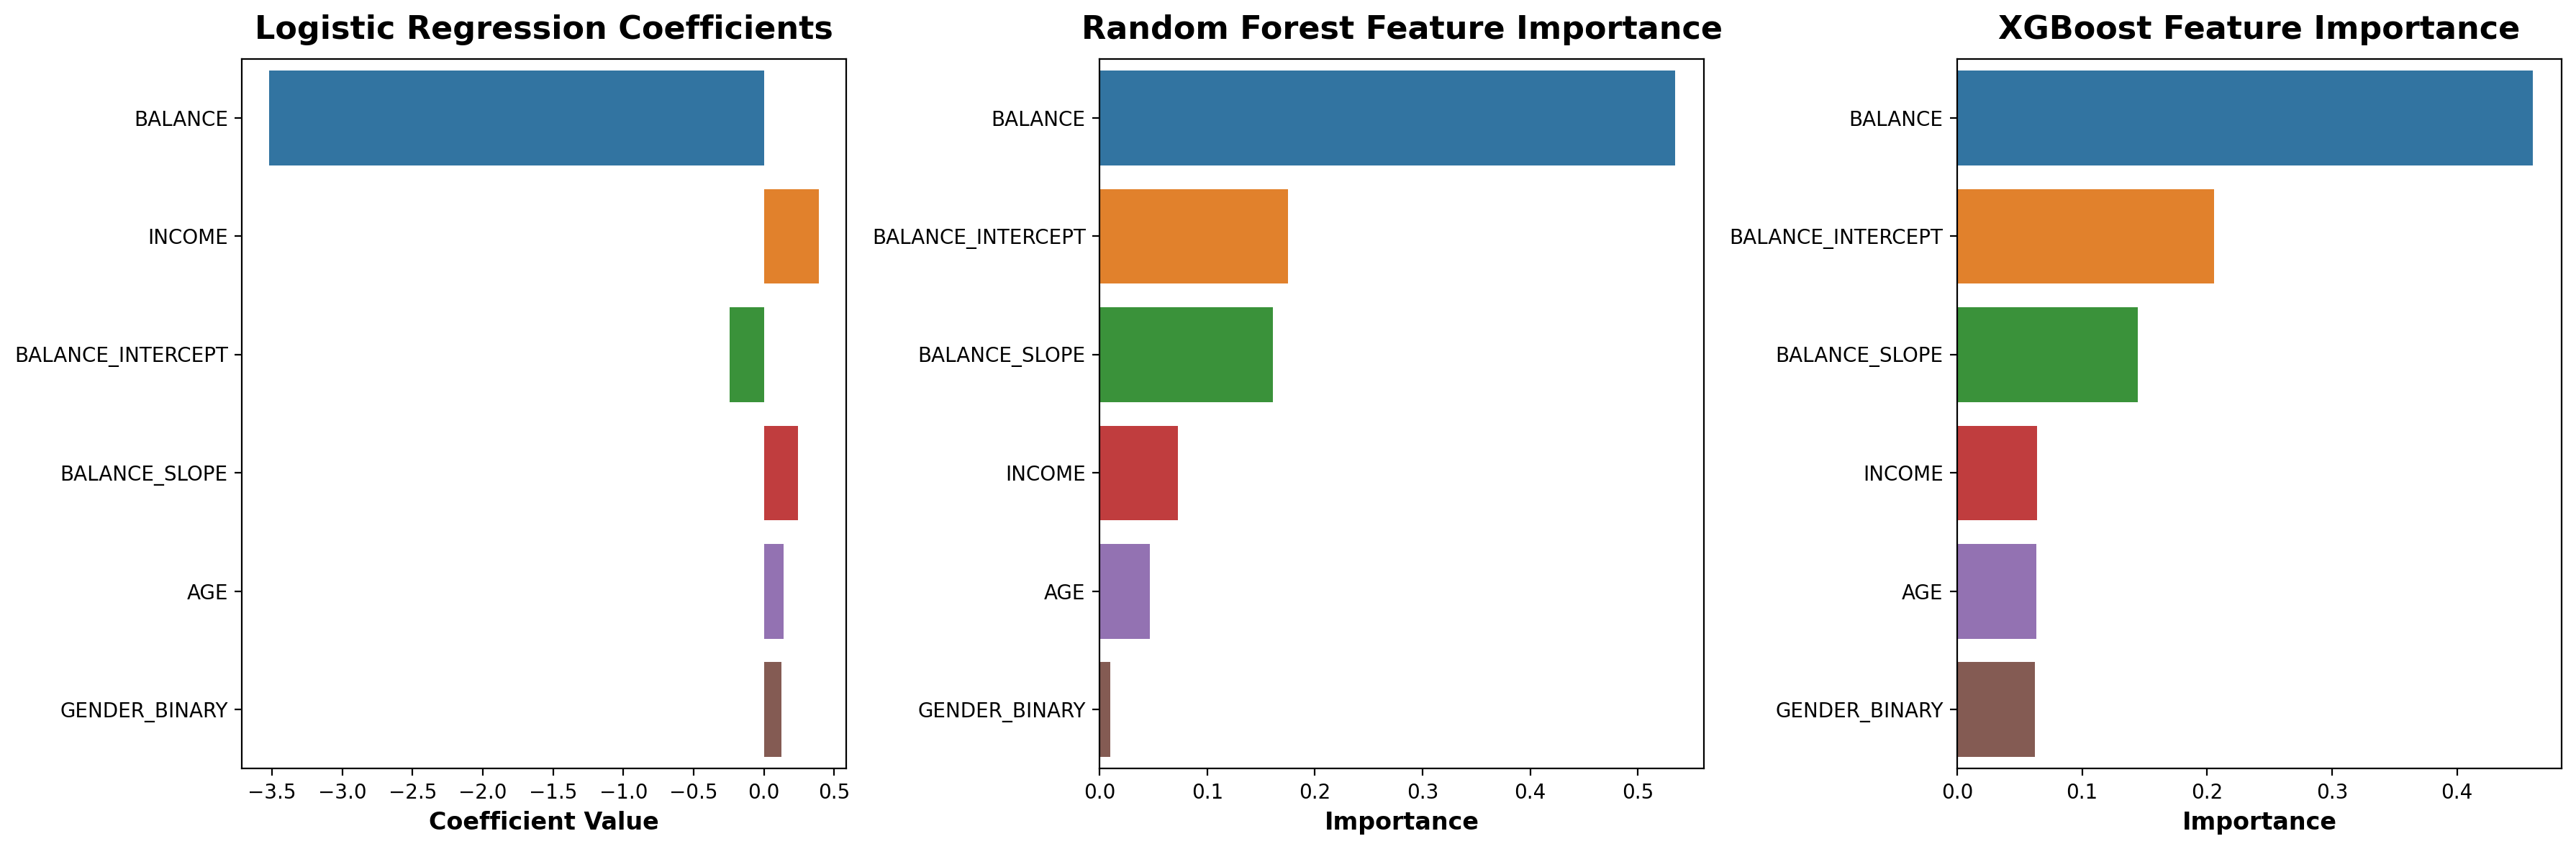

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression coefficients
lr_coefficients = pd.Series(log_reg.coef_[0], index=X.columns)
lr_coefficients = lr_coefficients.reindex(lr_coefficients.abs().sort_values(ascending=False).index)

sns.barplot(x=lr_coefficients.values, y=lr_coefficients.index, ax=axes[0])
axes[0].set_title("Logistic Regression Coefficients")
axes[0].set_xlabel("Coefficient Value")

# Random Forest feature importance
rf_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=False)

sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=axes[1])
axes[1].set_title("Random Forest Feature Importance")
axes[1].set_xlabel("Importance")

# XGBoost feature importance
xgb_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)
xgb_importances = xgb_importances.sort_values(ascending=False)

sns.barplot(x=xgb_importances.values, y=xgb_importances.index, ax=axes[2])
axes[2].set_title("XGBoost Feature Importance")
axes[2].set_xlabel("Importance")

plt.show()

As we expected, current balance is the most important feature across all models. Other features like income, balance slope, and balance intercept also play significant roles, though to a lesser extent.

##### **Conclusion** 

We will now be able to apply one of these models to identify which customers might need a loan. This solution can be further improved by:
- Trying other approaches to dealing with null values
- Exploring different methods for collecting the data for training (e.g., using different time windows)
- Tuning the model parameters
- Experimenting with other models
- Exploring alternative methods for describing balance movement
- Developing new features (e.g., how many times the customer has requested a loan)
- Trying a neural network approach, such as LSTM, for sequence classification (e.g., sequence of balances)